<a href="https://colab.research.google.com/github/AprilLH/testing/blob/master/yolo8v_with_sam_kaggle_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 + SAM2 Video Masking

This project uses YOLOv8 to detect objects in video frames and SAM (Segment Anything Model) to generate pixel-level masks for those detected objects. The result is an annotated video with semantic segmentation overlays.

## 🚀 Features
- Object detection using YOLOv8
- Mask generation using Meta AI's Segment Anything (SAM)
- Overlay masks on video frames
- Output full annotated video
- Option to skip frames for faster processing


## Import Packages

In [ ]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 136.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/12

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/driving-video-with-object-tracking")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/driving-video-with-object-tracking


In [ ]:
# Check actual file names
import os
print("Downloaded files:", os.listdir('/kaggle/input/driving-video-with-object-tracking'))

Downloaded files: ['mot_labels.csv', 'bdd100k_videos_train_00', 'mot_labels.parquet']


In [ ]:
import ultralytics
from IPython.display import display, Image
from roboflow import Roboflow
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
ultralytics.checks()

Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.6/112.6 GB disk)


In [ ]:
first_run = True
if first_run:
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_0papcwz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_0papcwz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=e632a16cd749413b820938bae13f602ac4347c365ad4a4fa1d59227801acbfb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fr7ti7h/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-05-11 21:09:56--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.22

In [ ]:
!pip install ultralytics opencv-python supervision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.7 MB/s eta 0:00:00


✅ Found 1000 .mov files, processing only the first one

▶️ Processing video: /kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/0000f77c-6257be58.mov
🎞️ Total frames: 1217, Resolution: 1280x720, FPS: 30.148637489677952

0: 384x640 3 cars, 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Frame 0 shape: (720, 1280, 3), Detections: 3


<ipython-input-9-3eb3f7c8a66e>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_id = int(box.cls.cpu().numpy())
<ipython-input-9-3eb3f7c8a66e>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(box.conf.cpu().numpy())


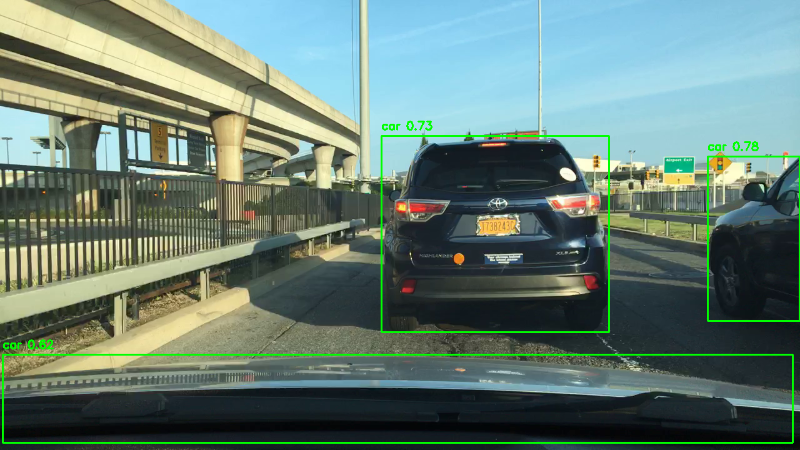


0: 384x640 3 cars, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 1 shape: (720, 1280, 3), Detections: 3


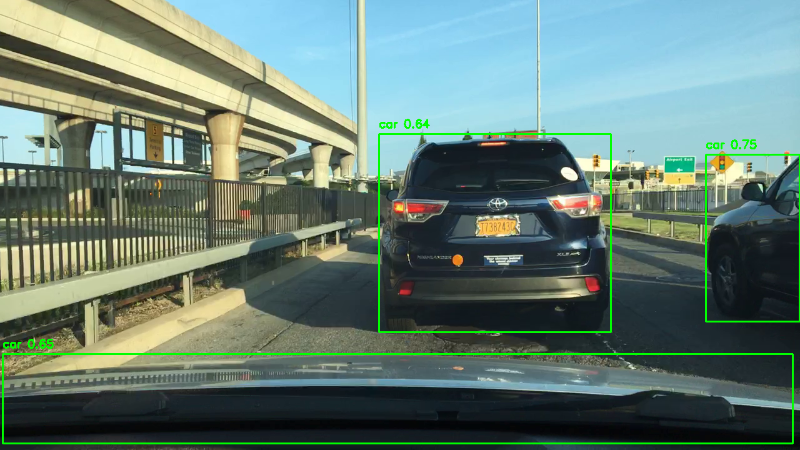


0: 384x640 3 cars, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 2 shape: (720, 1280, 3), Detections: 3


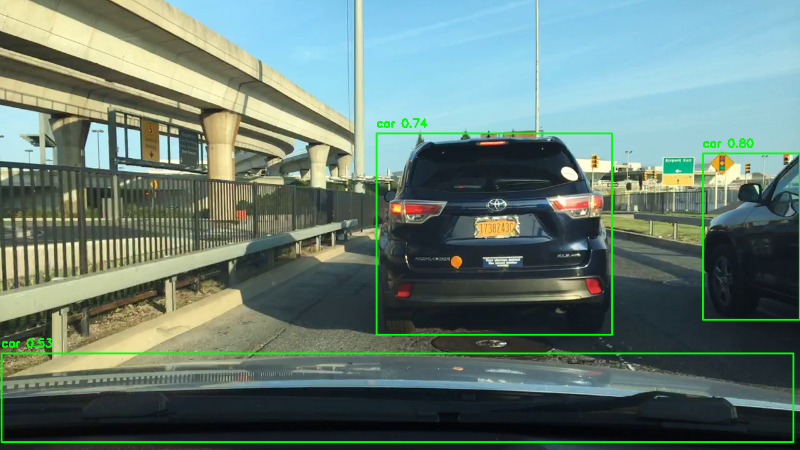


0: 384x640 3 cars, 12.1ms
Speed: 2.7ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 3 shape: (720, 1280, 3), Detections: 3


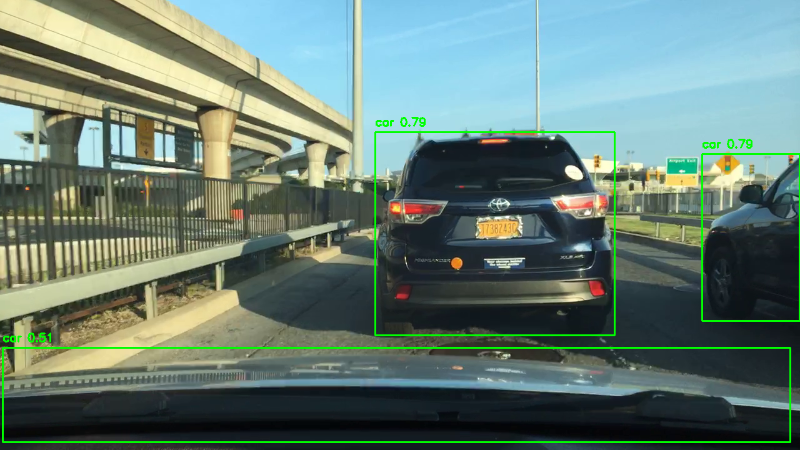


0: 384x640 3 cars, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 4 shape: (720, 1280, 3), Detections: 3


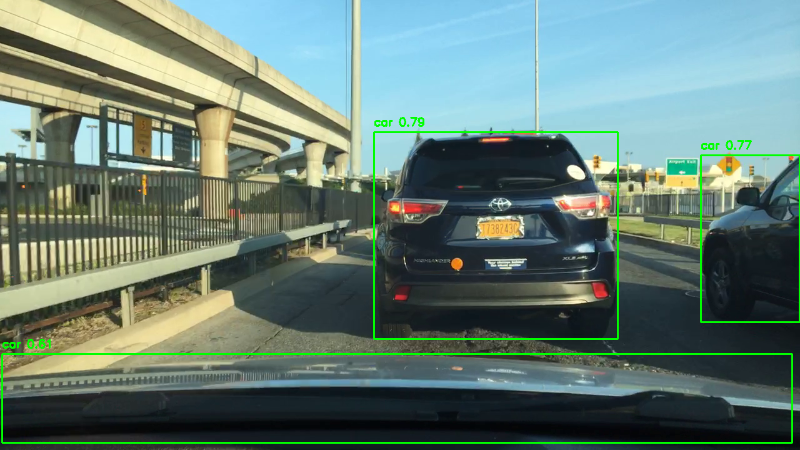


0: 384x640 3 cars, 12.7ms
Speed: 2.5ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 5 shape: (720, 1280, 3), Detections: 3


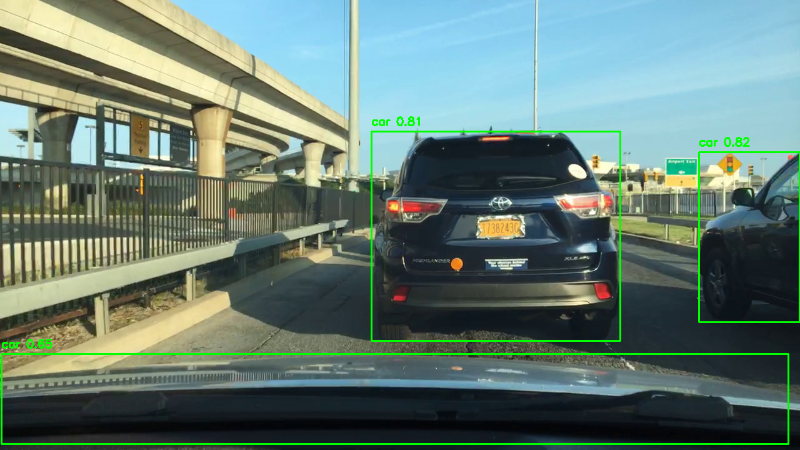


0: 384x640 3 cars, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 6 shape: (720, 1280, 3), Detections: 3


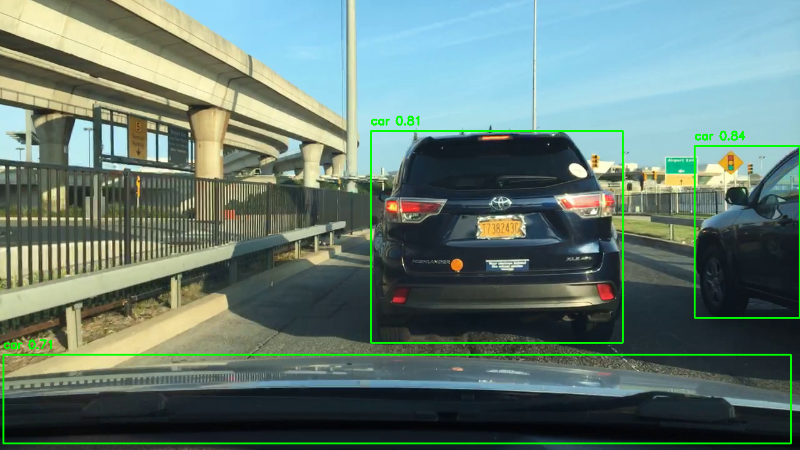


0: 384x640 3 cars, 14.4ms
Speed: 2.5ms preprocess, 14.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Frame 7 shape: (720, 1280, 3), Detections: 3


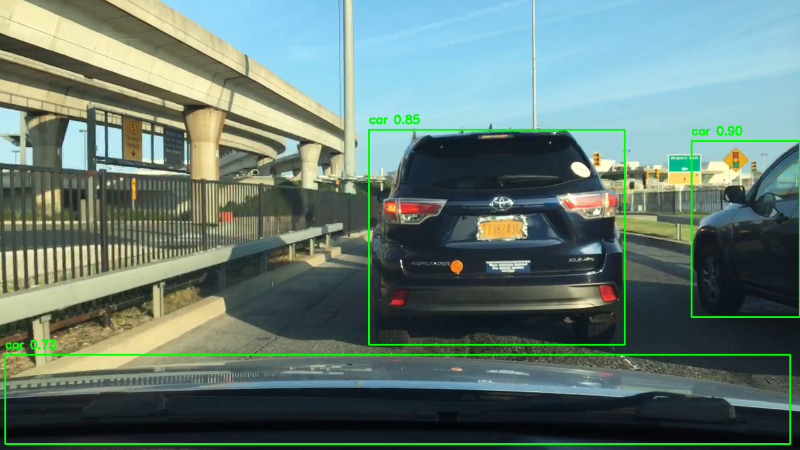


0: 384x640 3 cars, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
Frame 8 shape: (720, 1280, 3), Detections: 3


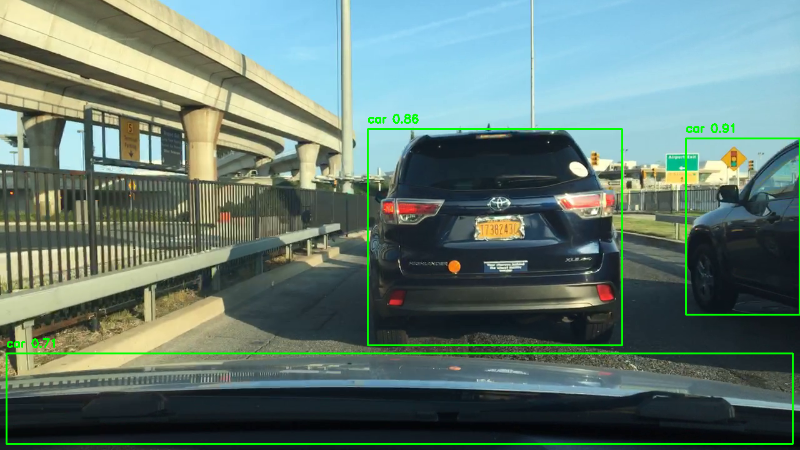


0: 384x640 3 cars, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 9 shape: (720, 1280, 3), Detections: 3


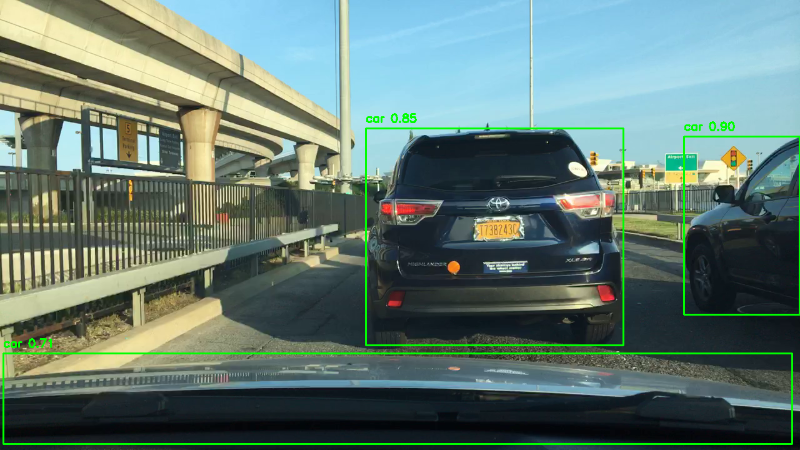


✅ Annotated video (10 frames) saved at: /content/yolo_annotated_output.mp4


In [ ]:
# runt the first 10 frames
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Dataset directory
dataset_dir = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/'
files = sorted(os.listdir(dataset_dir))
mov_files = [f for f in files if f.endswith('.mov')]

if len(mov_files) == 0:
    raise FileNotFoundError("❌ No .mov video files found in videos subdirectory")

print(f"✅ Found {len(mov_files)} .mov files, processing only the first one")

# Process the first video
file_name = mov_files[0]
video_file = os.path.join(dataset_dir, file_name)
print(f"\n▶️ Processing video: {video_file}")

# Open video
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    raise RuntimeError(f"❌ Failed to open video file: {video_file}")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# Output video writer
output_path = '/content/yolo_annotated_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process only first 10 frames for debugging
frame_count = 0
while cap.isOpened() and frame_count < 10:
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ Could not read frame {frame_count}")
        break

    results = model(frame)[0]
    print(f"Frame {frame_count} shape: {frame.shape}, Detections: {len(results.boxes)}")

    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            cls_id = int(box.cls.cpu().numpy())
            conf = float(box.conf.cpu().numpy())
            label = f"{model.names[cls_id]} {conf:.2f}"

            if model.names[cls_id] in ['car', 'bus', 'truck', 'train', 'person', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show frame to debug
    cv2_imshow(cv2.resize(frame, (800, 450)))

    # Write frame to video
    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"\n✅ Annotated video (10 frames) saved at: {output_path}")


In [ ]:
#play the first 10 frames
from IPython.display import HTML
from base64 import b64encode

video_path = "/content/yolo_annotated_output.mp4"

# Read the video and encode it to base64
mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Display the video in HTML
HTML(f"""
<video width=800 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")

In [ ]:
# run the first file in the folder
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Dataset directory
dataset_dir = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/'
files = sorted(os.listdir(dataset_dir))
mov_files = [f for f in files if f.endswith('.mov')]

if len(mov_files) == 0:
    raise FileNotFoundError("❌ No .mov video files found in videos subdirectory")

print(f"✅ Found {len(mov_files)} .mov files, processing only the first one")

# Process the first video
file_name = mov_files[0]
video_file = os.path.join(dataset_dir, file_name)
print(f"\n▶️ Processing video: {video_file}")

# Open video
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    raise RuntimeError(f"❌ Failed to open video file: {video_file}")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# Output video writer
output_path = '/content/yolo_annotated_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process all frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ Could not read frame {frame_count}")
        break

    results = model(frame)[0]
    print(f"Frame {frame_count} shape: {frame.shape}, Detections: {len(results.boxes)}")

    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            cls_id = int(box.cls.cpu().numpy())
            conf = float(box.conf.cpu().numpy())
            label = f"{model.names[cls_id]} {conf:.2f}"

            if model.names[cls_id] in ['car', 'bus', 'truck', 'train', 'person', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Optional: display every N frames (commented out for speed)
    # if frame_count % 50 == 0:
    #     cv2_imshow(cv2.resize(frame, (800, 450)))

    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"\n✅ Full annotated video saved at: {output_path}")


✅ Found 1000 .mov files, processing only the first one

▶️ Processing video: /kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/0000f77c-6257be58.mov
🎞️ Total frames: 1217, Resolution: 1280x720, FPS: 30.148637489677952

0: 384x640 3 cars, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Frame 0 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 1 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 2 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 3 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inf


0: 384x640 3 cars, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 7 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 8 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 9 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 10 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Frame 11 shape: (720, 1280, 3), Detections: 3

0: 384x640 3 cars, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 12 shape: (720, 1280, 3

In [ ]:
# specific file in the folder

import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Specify target video file
file_name = '00067cfb-5443fe39.mov'
dataset_dir = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/'
video_file = os.path.join(dataset_dir, file_name)
print(f"\n▶️ Processing video: {video_file}")

# Open video
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    raise RuntimeError(f"❌ Failed to open video file: {video_file}")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# Output video writer
output_path = '/content/yolo_annotated_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process all frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ Could not read frame {frame_count}")
        break

    results = model(frame)[0]
    print(f"Frame {frame_count} shape: {frame.shape}, Detections: {len(results.boxes)}")

    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            cls_id = int(box.cls.cpu().numpy())
            conf = float(box.conf.cpu().numpy())
            label = f"{model.names[cls_id]} {conf:.2f}"

            if model.names[cls_id] in ['car', 'bus', 'truck', 'train', 'person', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Optional: display every N frames (commented out for speed)
    # if frame_count % 50 == 0:
    #     cv2_imshow(cv2.resize(frame, (800, 450)))

    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"\n✅ Full annotated video saved at: {output_path}")



▶️ Processing video: /kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/00067cfb-5443fe39.mov
🎞️ Total frames: 1202, Resolution: 1280x720, FPS: 29.980046558031262

0: 384x640 14 cars, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Frame 0 shape: (720, 1280, 3), Detections: 14

0: 384x640 14 cars, 1 traffic light, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Frame 1 shape: (720, 1280, 3), Detections: 15

0: 384x640 16 cars, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Frame 2 shape: (720, 1280, 3), Detections: 16

0: 384x640 14 cars, 1 traffic light, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Frame 3 shape: (720, 1280, 3), Detections: 15

0: 384x640 13 cars, 1 traffic light, 11.4ms
Speed: 2.3ms preprocess, 11.4m

0: 384x640 13 cars, 14.4ms
Speed: 2.5ms preprocess, 14.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 5 shape: (720, 1280, 3), Detections: 13

0: 384x640 16 cars, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 6 shape: (720, 1280, 3), Detections: 16

0: 384x640 13 cars, 1 truck, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Frame 7 shape: (720, 1280, 3), Detections: 14

0: 384x640 13 cars, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Frame 8 shape: (720, 1280, 3), Detections: 13

0: 384x640 14 cars, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
Frame 9 shape: (720, 1280, 3), Detections: 14

0: 384x640 11 cars, 19.4ms
Speed: 2.3ms preprocess, 19.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Frame 10 sha

In [ ]:
# process every frame
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import torch

# Load YOLOv8 model
model = YOLO('yolov8s.pt')


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)

# Target video file
file_name = '00067cfb-5443fe39.mov'
dataset_dir = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/'
video_file = os.path.join(dataset_dir, file_name)
print(f"\n▶️ Processing video: {video_file}")

# Open video
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    raise RuntimeError(f"❌ Failed to open video file: {video_file}")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# Output video writer
output_path = '/content/sam_masked_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process all frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ Could not read frame {frame_count}")
        break

    results = model(frame)[0]
    print(f"Frame {frame_count} shape: {frame.shape}, Detections: {len(results.boxes)}")

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)

    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            cls_id = int(box.cls.cpu().numpy())
            if model.names[cls_id] in ['car', 'bus', 'truck', 'train', 'person', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                input_box = np.array([x1, y1, x2, y2])

                masks, scores, logits = predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False
                )

                mask = masks[0]
                color = np.array([30, 144, 255], dtype=np.uint8)
                overlay = np.zeros_like(frame, dtype=np.uint8)
                overlay[mask] = color
                frame = cv2.addWeighted(frame, 1.0, overlay, 0.5, 0)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"\n✅ Full masked video saved at: {output_path}")



▶️ Processing video: /kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/00067cfb-5443fe39.mov
🎞️ Total frames: 1202, Resolution: 1280x720, FPS: 29.980046558031262

0: 384x640 14 cars, 58.6ms
Speed: 17.4ms preprocess, 58.6ms inference, 344.4ms postprocess per image at shape (1, 3, 384, 640)
Frame 0 shape: (720, 1280, 3), Detections: 14


<ipython-input-5-bca21d4ff3f5>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_id = int(box.cls.cpu().numpy())



0: 384x640 14 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Frame 1 shape: (720, 1280, 3), Detections: 15

0: 384x640 16 cars, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Frame 2 shape: (720, 1280, 3), Detections: 16

0: 384x640 14 cars, 1 traffic light, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Frame 3 shape: (720, 1280, 3), Detections: 15

0: 384x640 13 cars, 1 traffic light, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Frame 4 shape: (720, 1280, 3), Detections: 14

0: 384x640 13 cars, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Frame 5 shape: (720, 1280, 3), Detections: 13

0: 384x640 16 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.4ms postprocess per image at sh

KeyboardInterrupt: 

In [ ]:
# only process every 3 frames to speed up, mask only
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import torch
import time

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Load SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)

# Target video file
file_name = '00067cfb-5443fe39.mov'
dataset_dir = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/'
video_file = os.path.join(dataset_dir, file_name)
print(f"\n▶️ Processing video: {video_file}")

# Open video
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    raise RuntimeError(f"❌ Failed to open video file: {video_file}")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# Output video writer
output_path = '/content/sam_masked_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process every 3rd frame with progress bar and ETA
frame_count = 0
processed = 0
start_time = time.time()

with tqdm(total=total_frames // 3, desc="Processing video") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % 3 != 0:
            frame_count += 1
            continue

        results = model(frame)[0]
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        predictor.set_image(image_rgb)

        if results.boxes is not None and len(results.boxes) > 0:
            for box in results.boxes:
                cls_id = int(box.cls.cpu().numpy())
                if model.names[cls_id] in ['car', 'bus', 'truck', 'train', 'person', 'bicycle', 'motorcycle']:
                    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                    input_box = np.array([x1, y1, x2, y2])

                    masks, scores, logits = predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False
                    )

                    mask = masks[0]
                    color = np.array([30, 144, 255], dtype=np.uint8)
                    overlay = np.zeros_like(frame, dtype=np.uint8)
                    overlay[mask] = color
                    frame = cv2.addWeighted(frame, 1.0, overlay, 0.5, 0)

        out.write(frame)
        frame_count += 1
        processed += 1
        pbar.update(1)

cap.release()
out.release()

elapsed = time.time() - start_time
print(f"\n✅ Masked video saved at: {output_path} in {elapsed:.2f} seconds.")



▶️ Processing video: /kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/00067cfb-5443fe39.mov
🎞️ Total frames: 1202, Resolution: 1280x720, FPS: 29.980046558031262


Processing video:   0%|          | 0/400 [00:00<?, ?it/s]


0: 384x640 14 cars, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


<ipython-input-6-15848f05ad03>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_id = int(box.cls.cpu().numpy())
Processing video:   0%|          | 1/400 [00:02<17:22,  2.61s/it]


0: 384x640 14 cars, 1 traffic light, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   0%|          | 2/400 [00:04<16:23,  2.47s/it]


0: 384x640 16 cars, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   1%|          | 3/400 [00:07<16:48,  2.54s/it]


0: 384x640 14 cars, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   1%|          | 4/400 [00:10<16:31,  2.50s/it]


0: 384x640 12 cars, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   1%|▏         | 5/400 [00:12<16:19,  2.48s/it]


0: 384x640 15 cars, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 6/400 [00:14<16:20,  2.49s/it]


0: 384x640 12 cars, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 7/400 [00:17<16:16,  2.49s/it]


0: 384x640 11 cars, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 8/400 [00:20<16:33,  2.54s/it]


0: 384x640 14 cars, 10.9ms
Speed: 3.9ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 9/400 [00:23<17:39,  2.71s/it]


0: 384x640 13 cars, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▎         | 10/400 [00:25<17:42,  2.72s/it]


0: 384x640 13 cars, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   3%|▎         | 11/400 [00:28<17:19,  2.67s/it]


0: 384x640 12 cars, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   3%|▎         | 12/400 [00:31<16:54,  2.61s/it]


0: 384x640 12 cars, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   3%|▎         | 13/400 [00:33<16:47,  2.60s/it]


0: 384x640 11 cars, 1 truck, 12.0ms
Speed: 2.6ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▎         | 14/400 [00:36<16:37,  2.58s/it]


0: 384x640 12 cars, 1 truck, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 15/400 [00:38<16:35,  2.59s/it]


0: 384x640 12 cars, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 16/400 [00:41<16:11,  2.53s/it]


0: 384x640 13 cars, 1 truck, 1 traffic light, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 17/400 [00:43<15:54,  2.49s/it]


0: 384x640 14 cars, 2 traffic lights, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 18/400 [00:45<15:39,  2.46s/it]


0: 384x640 15 cars, 1 traffic light, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   5%|▍         | 19/400 [00:48<15:48,  2.49s/it]


0: 384x640 15 cars, 1 traffic light, 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   5%|▌         | 20/400 [00:50<15:36,  2.47s/it]


0: 384x640 10 cars, 1 truck, 1 fire hydrant, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   5%|▌         | 21/400 [00:53<15:14,  2.41s/it]


0: 384x640 11 cars, 1 fire hydrant, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▌         | 22/400 [00:55<15:00,  2.38s/it]


0: 384x640 13 cars, 1 truck, 1 traffic light, 6.8ms
Speed: 3.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▌         | 23/400 [00:57<14:52,  2.37s/it]


0: 384x640 1 person, 12 cars, 1 truck, 1 traffic light, 1 fire hydrant, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▌         | 24/400 [01:00<15:02,  2.40s/it]


0: 384x640 1 person, 10 cars, 2 traffic lights, 1 fire hydrant, 12.1ms
Speed: 3.8ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▋         | 25/400 [01:02<14:45,  2.36s/it]


0: 384x640 9 cars, 1 traffic light, 1 fire hydrant, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▋         | 26/400 [01:04<14:29,  2.32s/it]


0: 384x640 1 person, 9 cars, 2 traffic lights, 1 fire hydrant, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   7%|▋         | 27/400 [01:07<14:19,  2.30s/it]


0: 384x640 1 person, 9 cars, 5 traffic lights, 1 fire hydrant, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   7%|▋         | 28/400 [01:09<14:09,  2.28s/it]


0: 384x640 9 cars, 4 traffic lights, 1 fire hydrant, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   7%|▋         | 29/400 [01:11<14:01,  2.27s/it]


0: 384x640 9 cars, 2 traffic lights, 1 fire hydrant, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 30/400 [01:13<14:07,  2.29s/it]


0: 384x640 10 cars, 1 traffic light, 1 fire hydrant, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 31/400 [01:16<14:02,  2.28s/it]


0: 384x640 7 cars, 1 traffic light, 1 fire hydrant, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 32/400 [01:18<13:51,  2.26s/it]


0: 384x640 7 cars, 1 traffic light, 1 fire hydrant, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 33/400 [01:20<13:45,  2.25s/it]


0: 384x640 10 cars, 1 fire hydrant, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 34/400 [01:22<13:45,  2.25s/it]


0: 384x640 1 person, 8 cars, 2 traffic lights, 1 fire hydrant, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   9%|▉         | 35/400 [01:25<13:42,  2.25s/it]


0: 384x640 9 cars, 2 traffic lights, 1 fire hydrant, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   9%|▉         | 36/400 [01:27<13:50,  2.28s/it]


0: 384x640 8 cars, 2 traffic lights, 1 fire hydrant, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   9%|▉         | 37/400 [01:29<13:45,  2.28s/it]


0: 384x640 1 person, 11 cars, 1 traffic light, 1 fire hydrant, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|▉         | 38/400 [01:32<13:51,  2.30s/it]


0: 384x640 11 cars, 2 traffic lights, 1 fire hydrant, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|▉         | 39/400 [01:34<13:50,  2.30s/it]


0: 384x640 13 cars, 2 traffic lights, 1 fire hydrant, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|█         | 40/400 [01:36<13:54,  2.32s/it]


0: 384x640 11 cars, 3 traffic lights, 1 fire hydrant, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|█         | 41/400 [01:39<14:02,  2.35s/it]


0: 384x640 1 person, 11 cars, 2 traffic lights, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|█         | 42/400 [01:41<14:07,  2.37s/it]


0: 384x640 10 cars, 4 traffic lights, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  11%|█         | 43/400 [01:43<14:00,  2.35s/it]


0: 384x640 1 person, 7 cars, 3 traffic lights, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  11%|█         | 44/400 [01:46<13:50,  2.33s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  11%|█▏        | 45/400 [01:48<13:44,  2.32s/it]


0: 384x640 8 cars, 4 traffic lights, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 46/400 [01:50<13:40,  2.32s/it]


0: 384x640 7 cars, 4 traffic lights, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 47/400 [01:53<13:42,  2.33s/it]


0: 384x640 7 cars, 5 traffic lights, 10.2ms
Speed: 4.5ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 48/400 [01:55<13:36,  2.32s/it]


0: 384x640 9 cars, 5 traffic lights, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 49/400 [01:57<13:53,  2.37s/it]


0: 384x640 9 cars, 4 traffic lights, 24.7ms
Speed: 7.6ms preprocess, 24.7ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▎        | 50/400 [02:00<13:58,  2.40s/it]


0: 384x640 10 cars, 4 traffic lights, 23.2ms
Speed: 2.5ms preprocess, 23.2ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  13%|█▎        | 51/400 [02:03<14:37,  2.51s/it]


0: 384x640 1 person, 10 cars, 3 traffic lights, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  13%|█▎        | 52/400 [02:05<14:51,  2.56s/it]


0: 384x640 1 person, 12 cars, 4 traffic lights, 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  13%|█▎        | 53/400 [02:08<14:51,  2.57s/it]


0: 384x640 1 person, 9 cars, 1 truck, 2 traffic lights, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▎        | 54/400 [02:10<14:30,  2.52s/it]


0: 384x640 1 person, 12 cars, 3 traffic lights, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 55/400 [02:13<14:34,  2.53s/it]


0: 384x640 1 person, 9 cars, 1 truck, 1 traffic light, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 56/400 [02:15<14:30,  2.53s/it]


0: 384x640 1 person, 6 cars, 1 truck, 4 traffic lights, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 57/400 [02:18<14:30,  2.54s/it]


0: 384x640 1 person, 9 cars, 1 truck, 6 traffic lights, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 58/400 [02:21<15:06,  2.65s/it]


0: 384x640 3 persons, 8 cars, 8 traffic lights, 14.1ms
Speed: 3.2ms preprocess, 14.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  15%|█▍        | 59/400 [02:23<14:37,  2.57s/it]


0: 384x640 2 persons, 5 cars, 6 traffic lights, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  15%|█▌        | 60/400 [02:25<14:01,  2.47s/it]


0: 384x640 3 persons, 5 cars, 1 truck, 6 traffic lights, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  15%|█▌        | 61/400 [02:28<13:38,  2.42s/it]


0: 384x640 3 persons, 5 cars, 3 traffic lights, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▌        | 62/400 [02:30<13:23,  2.38s/it]


0: 384x640 3 persons, 6 cars, 4 traffic lights, 1 stop sign, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▌        | 63/400 [02:32<13:23,  2.38s/it]


0: 384x640 2 persons, 6 cars, 1 truck, 3 traffic lights, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▌        | 64/400 [02:35<13:12,  2.36s/it]


0: 384x640 2 persons, 9 cars, 2 trucks, 5 traffic lights, 2 stop signs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▋        | 65/400 [02:37<13:09,  2.36s/it]


0: 384x640 2 persons, 6 cars, 4 traffic lights, 1 skateboard, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▋        | 66/400 [02:39<12:59,  2.33s/it]


0: 384x640 2 persons, 5 cars, 6 traffic lights, 1 skateboard, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  17%|█▋        | 67/400 [02:42<12:47,  2.30s/it]


0: 384x640 2 persons, 7 cars, 4 traffic lights, 1 skateboard, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  17%|█▋        | 68/400 [02:44<12:43,  2.30s/it]


0: 384x640 2 persons, 8 cars, 4 traffic lights, 1 skateboard, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  17%|█▋        | 69/400 [02:46<12:51,  2.33s/it]


0: 384x640 2 persons, 7 cars, 4 traffic lights, 1 skateboard, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 70/400 [02:49<12:46,  2.32s/it]


0: 384x640 2 persons, 9 cars, 3 traffic lights, 1 skateboard, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 71/400 [02:51<12:44,  2.32s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 72/400 [02:53<12:37,  2.31s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 73/400 [02:55<12:31,  2.30s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 74/400 [02:58<12:37,  2.32s/it]


0: 384x640 1 person, 10 cars, 5 traffic lights, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  19%|█▉        | 75/400 [03:00<12:52,  2.38s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  19%|█▉        | 76/400 [03:03<12:39,  2.34s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  19%|█▉        | 77/400 [03:05<12:27,  2.31s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|█▉        | 78/400 [03:07<12:19,  2.30s/it]


0: 384x640 1 person, 6 cars, 5 traffic lights, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|█▉        | 79/400 [03:09<12:13,  2.28s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|██        | 80/400 [03:12<12:22,  2.32s/it]


0: 384x640 1 person, 5 cars, 4 traffic lights, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|██        | 81/400 [03:14<12:14,  2.30s/it]


0: 384x640 2 persons, 6 cars, 3 traffic lights, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|██        | 82/400 [03:16<12:08,  2.29s/it]


0: 384x640 1 person, 6 cars, 4 traffic lights, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  21%|██        | 83/400 [03:19<12:10,  2.30s/it]


0: 384x640 1 person, 5 cars, 5 traffic lights, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  21%|██        | 84/400 [03:21<12:11,  2.32s/it]


0: 384x640 2 persons, 4 cars, 3 traffic lights, 10.7ms
Speed: 5.5ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  21%|██▏       | 85/400 [03:23<12:04,  2.30s/it]


0: 384x640 1 person, 4 cars, 4 traffic lights, 1 handbag, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 86/400 [03:26<12:00,  2.29s/it]


0: 384x640 2 persons, 4 cars, 3 traffic lights, 2 handbags, 9.1ms
Speed: 5.6ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 87/400 [03:28<11:52,  2.28s/it]


0: 384x640 2 persons, 4 cars, 4 traffic lights, 1 handbag, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 88/400 [03:30<11:46,  2.26s/it]


0: 384x640 1 person, 6 cars, 3 traffic lights, 8.6ms
Speed: 6.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 89/400 [03:32<11:42,  2.26s/it]


0: 384x640 1 person, 6 cars, 2 traffic lights, 1 kite, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▎       | 90/400 [03:35<11:40,  2.26s/it]


0: 384x640 1 person, 6 cars, 1 traffic light, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  23%|██▎       | 91/400 [03:37<11:38,  2.26s/it]


0: 384x640 1 person, 5 cars, 1 skateboard, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  23%|██▎       | 92/400 [03:39<11:43,  2.28s/it]


0: 384x640 5 cars, 17.0ms
Speed: 2.5ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  23%|██▎       | 93/400 [03:41<11:37,  2.27s/it]


0: 384x640 4 cars, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▎       | 94/400 [03:44<11:28,  2.25s/it]


0: 384x640 6 cars, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 95/400 [03:46<11:25,  2.25s/it]


0: 384x640 8 cars, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 96/400 [03:48<11:25,  2.26s/it]


0: 384x640 7 cars, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 97/400 [03:50<11:31,  2.28s/it]


0: 384x640 9 cars, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 98/400 [03:53<11:43,  2.33s/it]


0: 384x640 1 person, 8 cars, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  25%|██▍       | 99/400 [03:55<11:39,  2.32s/it]


0: 384x640 2 persons, 9 cars, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  25%|██▌       | 100/400 [03:57<11:36,  2.32s/it]


0: 384x640 2 persons, 8 cars, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  25%|██▌       | 101/400 [04:00<11:33,  2.32s/it]


0: 384x640 1 person, 8 cars, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▌       | 102/400 [04:02<11:28,  2.31s/it]


0: 384x640 1 person, 10 cars, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▌       | 103/400 [04:05<11:38,  2.35s/it]


0: 384x640 1 person, 8 cars, 9.2ms
Speed: 4.1ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▌       | 104/400 [04:07<11:31,  2.34s/it]


0: 384x640 1 person, 8 cars, 1 backpack, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▋       | 105/400 [04:09<11:26,  2.33s/it]


0: 384x640 1 person, 7 cars, 12.6ms
Speed: 3.7ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▋       | 106/400 [04:11<11:20,  2.31s/it]


0: 384x640 1 person, 8 cars, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  27%|██▋       | 107/400 [04:14<11:16,  2.31s/it]


0: 384x640 1 person, 12 cars, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  27%|██▋       | 108/400 [04:16<11:18,  2.33s/it]


0: 384x640 11 cars, 16.3ms
Speed: 4.7ms preprocess, 16.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  27%|██▋       | 109/400 [04:19<11:30,  2.37s/it]


0: 384x640 12 cars, 12.6ms
Speed: 2.5ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 110/400 [04:21<11:28,  2.37s/it]


0: 384x640 11 cars, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 111/400 [04:23<11:21,  2.36s/it]


0: 384x640 12 cars, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 112/400 [04:26<11:18,  2.36s/it]


0: 384x640 13 cars, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 113/400 [04:28<11:17,  2.36s/it]


0: 384x640 1 person, 11 cars, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 114/400 [04:31<11:28,  2.41s/it]


0: 384x640 11 cars, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  29%|██▉       | 115/400 [04:33<11:20,  2.39s/it]


0: 384x640 9 cars, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  29%|██▉       | 116/400 [04:35<11:11,  2.36s/it]


0: 384x640 9 cars, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  29%|██▉       | 117/400 [04:37<11:03,  2.34s/it]


0: 384x640 9 cars, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|██▉       | 118/400 [04:40<10:57,  2.33s/it]


0: 384x640 9 cars, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|██▉       | 119/400 [04:42<10:52,  2.32s/it]


0: 384x640 11 cars, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|███       | 120/400 [04:45<11:02,  2.37s/it]


0: 384x640 13 cars, 15.0ms
Speed: 2.4ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|███       | 121/400 [04:47<11:00,  2.37s/it]


0: 384x640 9 cars, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|███       | 122/400 [04:49<10:51,  2.34s/it]


0: 384x640 7 cars, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  31%|███       | 123/400 [04:51<10:42,  2.32s/it]


0: 384x640 10 cars, 1 traffic light, 7.7ms
Speed: 4.1ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  31%|███       | 124/400 [04:54<10:39,  2.32s/it]


0: 384x640 10 cars, 1 traffic light, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  31%|███▏      | 125/400 [04:56<10:48,  2.36s/it]


0: 384x640 11 cars, 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 126/400 [04:59<10:45,  2.35s/it]


0: 384x640 10 cars, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 127/400 [05:01<10:38,  2.34s/it]


0: 384x640 9 cars, 1 traffic light, 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 128/400 [05:03<10:32,  2.33s/it]


0: 384x640 10 cars, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 129/400 [05:05<10:30,  2.33s/it]


0: 384x640 11 cars, 6.9ms
Speed: 3.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▎      | 130/400 [05:08<10:28,  2.33s/it]


0: 384x640 10 cars, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  33%|███▎      | 131/400 [05:10<10:33,  2.36s/it]


0: 384x640 10 cars, 15.2ms
Speed: 2.8ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  33%|███▎      | 132/400 [05:13<10:29,  2.35s/it]


0: 384x640 7 cars, 1 traffic light, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  33%|███▎      | 133/400 [05:15<10:21,  2.33s/it]


0: 384x640 9 cars, 2 traffic lights, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▎      | 134/400 [05:17<10:17,  2.32s/it]


0: 384x640 8 cars, 2 traffic lights, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 135/400 [05:19<10:12,  2.31s/it]


0: 384x640 9 cars, 2 traffic lights, 6.9ms
Speed: 3.7ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 136/400 [05:22<10:17,  2.34s/it]


0: 384x640 9 cars, 2 traffic lights, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 137/400 [05:24<10:24,  2.37s/it]


0: 384x640 3 persons, 7 cars, 1 traffic light, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 138/400 [05:27<10:19,  2.36s/it]


0: 384x640 2 persons, 6 cars, 2 traffic lights, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  35%|███▍      | 139/400 [05:29<10:09,  2.34s/it]


0: 384x640 2 persons, 8 cars, 1 traffic light, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  35%|███▌      | 140/400 [05:31<10:06,  2.33s/it]


0: 384x640 1 person, 8 cars, 1 traffic light, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  35%|███▌      | 141/400 [05:34<10:01,  2.32s/it]


0: 384x640 7 cars, 1 traffic light, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▌      | 142/400 [05:36<10:00,  2.33s/it]


0: 384x640 7 cars, 2 traffic lights, 10.3ms
Speed: 5.6ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▌      | 143/400 [05:38<09:54,  2.31s/it]


0: 384x640 7 cars, 1 traffic light, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▌      | 144/400 [05:40<09:48,  2.30s/it]


0: 384x640 6 cars, 1 traffic light, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▋      | 145/400 [05:43<09:41,  2.28s/it]


0: 384x640 7 cars, 3 traffic lights, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▋      | 146/400 [05:45<09:38,  2.28s/it]


0: 384x640 9 cars, 2 traffic lights, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  37%|███▋      | 147/400 [05:47<09:37,  2.28s/it]


0: 384x640 10 cars, 2 traffic lights, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  37%|███▋      | 148/400 [05:50<09:44,  2.32s/it]


0: 384x640 8 cars, 4 traffic lights, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  37%|███▋      | 149/400 [05:52<09:40,  2.31s/it]


0: 384x640 7 cars, 4 traffic lights, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 150/400 [05:54<09:34,  2.30s/it]


0: 384x640 7 cars, 3 traffic lights, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 151/400 [05:56<09:30,  2.29s/it]


0: 384x640 6 cars, 3 traffic lights, 7.0ms
Speed: 4.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 152/400 [05:59<09:24,  2.28s/it]


0: 384x640 8 cars, 4 traffic lights, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 153/400 [06:01<09:27,  2.30s/it]


0: 384x640 7 cars, 5 traffic lights, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 154/400 [06:03<09:32,  2.33s/it]


0: 384x640 7 cars, 5 traffic lights, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  39%|███▉      | 155/400 [06:06<09:36,  2.35s/it]


0: 384x640 10 cars, 4 traffic lights, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  39%|███▉      | 156/400 [06:08<09:33,  2.35s/it]


0: 384x640 9 cars, 5 traffic lights, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  39%|███▉      | 157/400 [06:11<09:26,  2.33s/it]


0: 384x640 8 cars, 2 traffic lights, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|███▉      | 158/400 [06:13<09:19,  2.31s/it]


0: 384x640 12 cars, 1 truck, 2 traffic lights, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|███▉      | 159/400 [06:15<09:24,  2.34s/it]


0: 384x640 9 cars, 1 truck, 3 traffic lights, 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|████      | 160/400 [06:18<09:28,  2.37s/it]


0: 384x640 11 cars, 5 traffic lights, 11.2ms
Speed: 6.5ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|████      | 161/400 [06:20<09:24,  2.36s/it]


0: 384x640 9 cars, 5 traffic lights, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|████      | 162/400 [06:22<09:17,  2.34s/it]


0: 384x640 9 cars, 8 traffic lights, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  41%|████      | 163/400 [06:25<09:13,  2.33s/it]


0: 384x640 9 cars, 4 traffic lights, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  41%|████      | 164/400 [06:27<09:08,  2.32s/it]


0: 384x640 10 cars, 6 traffic lights, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  41%|████▏     | 165/400 [06:29<09:13,  2.35s/it]


0: 384x640 7 cars, 6 traffic lights, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 166/400 [06:32<09:06,  2.33s/it]


0: 384x640 7 cars, 5 traffic lights, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 167/400 [06:34<08:58,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 168/400 [06:36<08:55,  2.31s/it]


0: 384x640 3 persons, 8 cars, 1 bus, 5 traffic lights, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 169/400 [06:39<08:56,  2.32s/it]


0: 384x640 1 person, 9 cars, 8 traffic lights, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▎     | 170/400 [06:41<08:53,  2.32s/it]


0: 384x640 9 cars, 6 traffic lights, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  43%|████▎     | 171/400 [06:43<08:58,  2.35s/it]


0: 384x640 8 cars, 8 traffic lights, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  43%|████▎     | 172/400 [06:46<08:52,  2.34s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  43%|████▎     | 173/400 [06:48<08:47,  2.32s/it]


0: 384x640 8 cars, 1 truck, 4 traffic lights, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▎     | 174/400 [06:50<08:44,  2.32s/it]


0: 384x640 8 cars, 1 truck, 5 traffic lights, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 175/400 [06:52<08:39,  2.31s/it]


0: 384x640 7 cars, 1 bus, 1 truck, 5 traffic lights, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 176/400 [06:55<08:44,  2.34s/it]


0: 384x640 8 cars, 4 traffic lights, 10.3ms
Speed: 5.7ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 177/400 [06:57<08:46,  2.36s/it]


0: 384x640 7 cars, 5 traffic lights, 17.7ms
Speed: 2.4ms preprocess, 17.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 178/400 [07:00<08:38,  2.34s/it]


0: 384x640 8 cars, 4 traffic lights, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  45%|████▍     | 179/400 [07:02<08:32,  2.32s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  45%|████▌     | 180/400 [07:04<08:28,  2.31s/it]


0: 384x640 9 cars, 5 traffic lights, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  45%|████▌     | 181/400 [07:06<08:23,  2.30s/it]


0: 384x640 10 cars, 2 traffic lights, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▌     | 182/400 [07:09<08:28,  2.33s/it]


0: 384x640 2 persons, 8 cars, 1 bus, 1 truck, 4 traffic lights, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▌     | 183/400 [07:11<08:28,  2.34s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▌     | 184/400 [07:13<08:21,  2.32s/it]


0: 384x640 9 cars, 2 trucks, 5 traffic lights, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▋     | 185/400 [07:16<08:18,  2.32s/it]


0: 384x640 10 cars, 1 truck, 4 traffic lights, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▋     | 186/400 [07:18<08:15,  2.32s/it]


0: 384x640 8 cars, 2 trucks, 4 traffic lights, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  47%|████▋     | 187/400 [07:20<08:12,  2.31s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 12.0ms
Speed: 2.5ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  47%|████▋     | 188/400 [07:23<08:15,  2.34s/it]


0: 384x640 1 person, 6 cars, 2 trucks, 8 traffic lights, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  47%|████▋     | 189/400 [07:25<08:12,  2.33s/it]


0: 384x640 6 cars, 1 truck, 6 traffic lights, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 190/400 [07:27<08:04,  2.31s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 4 traffic lights, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 191/400 [07:30<08:01,  2.30s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 5 traffic lights, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 192/400 [07:32<07:58,  2.30s/it]


0: 384x640 2 persons, 8 cars, 2 trucks, 4 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 193/400 [07:34<08:09,  2.36s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 3 traffic lights, 10.2ms
Speed: 2.4ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 194/400 [07:37<08:04,  2.35s/it]


0: 384x640 3 persons, 5 cars, 2 trucks, 3 traffic lights, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  49%|████▉     | 195/400 [07:39<08:00,  2.34s/it]


0: 384x640 2 persons, 7 cars, 1 truck, 5 traffic lights, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  49%|████▉     | 196/400 [07:41<07:55,  2.33s/it]


0: 384x640 7 cars, 1 truck, 6 traffic lights, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  49%|████▉     | 197/400 [07:44<07:51,  2.32s/it]


0: 384x640 2 persons, 2 cars, 1 truck, 7 traffic lights, 7.7ms
Speed: 3.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|████▉     | 198/400 [07:46<07:43,  2.30s/it]


0: 384x640 1 person, 3 cars, 1 truck, 7 traffic lights, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|████▉     | 199/400 [07:48<07:41,  2.30s/it]


0: 384x640 1 person, 3 cars, 1 truck, 5 traffic lights, 18.4ms
Speed: 2.4ms preprocess, 18.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|█████     | 200/400 [07:50<07:37,  2.29s/it]


0: 384x640 1 person, 3 cars, 1 truck, 6 traffic lights, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|█████     | 201/400 [07:53<07:32,  2.27s/it]


0: 384x640 3 cars, 1 truck, 6 traffic lights, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|█████     | 202/400 [07:55<07:26,  2.26s/it]


0: 384x640 2 cars, 1 truck, 6 traffic lights, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  51%|█████     | 203/400 [07:57<07:20,  2.24s/it]


0: 384x640 2 cars, 1 truck, 5 traffic lights, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  51%|█████     | 204/400 [07:59<07:17,  2.23s/it]


0: 384x640 2 cars, 2 trucks, 5 traffic lights, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  51%|█████▏    | 205/400 [08:02<07:16,  2.24s/it]


0: 384x640 1 car, 2 trucks, 6 traffic lights, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 206/400 [08:04<07:13,  2.24s/it]


0: 384x640 2 cars, 2 trucks, 5 traffic lights, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 207/400 [08:06<07:10,  2.23s/it]


0: 384x640 1 person, 3 cars, 2 trucks, 5 traffic lights, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 208/400 [08:08<07:08,  2.23s/it]


0: 384x640 2 persons, 5 cars, 2 trucks, 6 traffic lights, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 209/400 [08:11<07:10,  2.25s/it]


0: 384x640 2 persons, 3 cars, 2 trucks, 5 traffic lights, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▎    | 210/400 [08:13<07:12,  2.28s/it]


0: 384x640 2 persons, 5 cars, 1 truck, 6 traffic lights, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  53%|█████▎    | 211/400 [08:15<07:17,  2.31s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 5 traffic lights, 11.5ms
Speed: 3.6ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  53%|█████▎    | 212/400 [08:18<07:15,  2.32s/it]


0: 384x640 2 persons, 7 cars, 2 trucks, 6 traffic lights, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  53%|█████▎    | 213/400 [08:20<07:13,  2.32s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 5 traffic lights, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▎    | 214/400 [08:22<07:12,  2.32s/it]


0: 384x640 3 persons, 10 cars, 5 traffic lights, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▍    | 215/400 [08:25<07:10,  2.33s/it]


0: 384x640 3 persons, 7 cars, 6 traffic lights, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▍    | 216/400 [08:27<07:12,  2.35s/it]


0: 384x640 4 persons, 5 cars, 6 traffic lights, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▍    | 217/400 [08:29<07:06,  2.33s/it]


0: 384x640 2 persons, 6 cars, 6 traffic lights, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▍    | 218/400 [08:32<07:00,  2.31s/it]


0: 384x640 1 person, 6 cars, 4 traffic lights, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▍    | 219/400 [08:34<06:55,  2.30s/it]


0: 384x640 3 persons, 8 cars, 5 traffic lights, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▌    | 220/400 [08:36<06:53,  2.30s/it]


0: 384x640 2 persons, 8 cars, 5 traffic lights, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▌    | 221/400 [08:38<06:50,  2.29s/it]


0: 384x640 2 persons, 8 cars, 6 traffic lights, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▌    | 222/400 [08:41<06:53,  2.32s/it]


0: 384x640 2 persons, 10 cars, 6 traffic lights, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▌    | 223/400 [08:43<06:53,  2.34s/it]


0: 384x640 2 persons, 8 cars, 6 traffic lights, 1 skateboard, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▌    | 224/400 [08:46<06:52,  2.34s/it]


0: 384x640 3 persons, 9 cars, 1 truck, 5 traffic lights, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▋    | 225/400 [08:48<06:59,  2.40s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 6 traffic lights, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▋    | 226/400 [08:50<06:56,  2.39s/it]


0: 384x640 3 persons, 11 cars, 1 truck, 6 traffic lights, 1 skateboard, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▋    | 227/400 [08:53<07:03,  2.45s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 6 traffic lights, 1 skateboard, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▋    | 228/400 [08:55<06:56,  2.42s/it]


0: 384x640 2 persons, 7 cars, 2 trucks, 6 traffic lights, 1 skateboard, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▋    | 229/400 [08:58<06:48,  2.39s/it]


0: 384x640 1 person, 8 cars, 2 trucks, 6 traffic lights, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▊    | 230/400 [09:00<06:43,  2.38s/it]


0: 384x640 3 persons, 7 cars, 3 trucks, 6 traffic lights, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 231/400 [09:02<06:40,  2.37s/it]


0: 384x640 2 persons, 7 cars, 2 trucks, 6 traffic lights, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 232/400 [09:05<06:35,  2.36s/it]


0: 384x640 2 persons, 5 cars, 3 trucks, 6 traffic lights, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 233/400 [09:07<06:38,  2.39s/it]


0: 384x640 3 persons, 4 cars, 3 trucks, 5 traffic lights, 13.2ms
Speed: 2.4ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 234/400 [09:10<06:33,  2.37s/it]


0: 384x640 6 cars, 1 truck, 6 traffic lights, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  59%|█████▉    | 235/400 [09:12<06:25,  2.34s/it]


0: 384x640 2 persons, 6 cars, 1 bus, 2 trucks, 6 traffic lights, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  59%|█████▉    | 236/400 [09:14<06:23,  2.34s/it]


0: 384x640 2 persons, 4 cars, 1 truck, 6 traffic lights, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  59%|█████▉    | 237/400 [09:16<06:16,  2.31s/it]


0: 384x640 2 persons, 6 cars, 1 truck, 6 traffic lights, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|█████▉    | 238/400 [09:19<06:18,  2.34s/it]


0: 384x640 2 persons, 4 cars, 1 truck, 6 traffic lights, 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|█████▉    | 239/400 [09:21<06:13,  2.32s/it]


0: 384x640 3 cars, 1 bus, 1 truck, 6 traffic lights, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|██████    | 240/400 [09:23<06:06,  2.29s/it]


0: 384x640 3 persons, 2 cars, 1 truck, 4 traffic lights, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|██████    | 241/400 [09:26<06:03,  2.29s/it]


0: 384x640 2 persons, 2 cars, 1 bus, 2 trucks, 5 traffic lights, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|██████    | 242/400 [09:28<06:00,  2.28s/it]


0: 384x640 2 persons, 3 cars, 2 trucks, 5 traffic lights, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  61%|██████    | 243/400 [09:30<05:57,  2.28s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  61%|██████    | 244/400 [09:32<05:57,  2.29s/it]


0: 384x640 2 persons, 3 cars, 1 truck, 5 traffic lights, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  61%|██████▏   | 245/400 [09:35<05:53,  2.28s/it]


0: 384x640 2 persons, 4 cars, 1 truck, 4 traffic lights, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 246/400 [09:37<05:50,  2.28s/it]


0: 384x640 1 person, 4 cars, 1 truck, 5 traffic lights, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 247/400 [09:39<05:46,  2.26s/it]


0: 384x640 1 person, 5 cars, 1 truck, 5 traffic lights, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 248/400 [09:41<05:43,  2.26s/it]


0: 384x640 1 person, 5 cars, 1 truck, 4 traffic lights, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 249/400 [09:44<05:41,  2.26s/it]


0: 384x640 1 person, 6 cars, 1 truck, 5 traffic lights, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▎   | 250/400 [09:46<05:43,  2.29s/it]


0: 384x640 6 cars, 1 truck, 5 traffic lights, 24.1ms
Speed: 2.4ms preprocess, 24.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  63%|██████▎   | 251/400 [09:48<05:41,  2.29s/it]


0: 384x640 1 person, 6 cars, 1 truck, 6 traffic lights, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  63%|██████▎   | 252/400 [09:51<05:38,  2.29s/it]


0: 384x640 2 persons, 5 cars, 1 truck, 5 traffic lights, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  63%|██████▎   | 253/400 [09:53<05:35,  2.28s/it]


0: 384x640 3 persons, 5 cars, 1 truck, 4 traffic lights, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▎   | 254/400 [09:55<05:34,  2.29s/it]


0: 384x640 3 persons, 5 cars, 1 truck, 5 traffic lights, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 255/400 [09:58<05:35,  2.31s/it]


0: 384x640 2 persons, 6 cars, 1 bus, 1 truck, 4 traffic lights, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 256/400 [10:00<05:36,  2.34s/it]


0: 384x640 2 persons, 6 cars, 1 truck, 7 traffic lights, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 257/400 [10:02<05:32,  2.33s/it]


0: 384x640 3 persons, 6 cars, 7 traffic lights, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 258/400 [10:05<05:28,  2.31s/it]


0: 384x640 1 person, 7 cars, 1 truck, 7 traffic lights, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  65%|██████▍   | 259/400 [10:07<05:25,  2.31s/it]


0: 384x640 2 persons, 6 cars, 1 bus, 1 truck, 7 traffic lights, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  65%|██████▌   | 260/400 [10:09<05:22,  2.30s/it]


0: 384x640 6 cars, 1 bus, 1 truck, 7 traffic lights, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  65%|██████▌   | 261/400 [10:11<05:21,  2.32s/it]


0: 384x640 2 persons, 7 cars, 1 bus, 1 truck, 7 traffic lights, 13.1ms
Speed: 2.4ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▌   | 262/400 [10:14<05:21,  2.33s/it]


0: 384x640 2 persons, 9 cars, 2 buss, 1 truck, 7 traffic lights, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▌   | 263/400 [10:16<05:22,  2.35s/it]


0: 384x640 2 persons, 8 cars, 1 bus, 1 truck, 7 traffic lights, 9.1ms
Speed: 4.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▌   | 264/400 [10:19<05:19,  2.35s/it]


0: 384x640 2 persons, 8 cars, 1 truck, 7 traffic lights, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▋   | 265/400 [10:21<05:15,  2.34s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 7 traffic lights, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▋   | 266/400 [10:23<05:19,  2.39s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 6 traffic lights, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  67%|██████▋   | 267/400 [10:26<05:22,  2.43s/it]


0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 5 traffic lights, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  67%|██████▋   | 268/400 [10:28<05:17,  2.40s/it]


0: 384x640 2 persons, 8 cars, 1 bus, 1 truck, 4 traffic lights, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  67%|██████▋   | 269/400 [10:31<05:12,  2.39s/it]


0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 4 traffic lights, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 270/400 [10:33<05:08,  2.37s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 4 traffic lights, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 271/400 [10:35<05:04,  2.36s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 4 traffic lights, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 272/400 [10:38<05:07,  2.40s/it]


0: 384x640 2 persons, 11 cars, 1 truck, 5 traffic lights, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 273/400 [10:40<05:05,  2.40s/it]


0: 384x640 3 persons, 12 cars, 1 truck, 5 traffic lights, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 274/400 [10:43<05:02,  2.40s/it]


0: 384x640 1 person, 13 cars, 1 truck, 4 traffic lights, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  69%|██████▉   | 275/400 [10:45<04:59,  2.39s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 4 traffic lights, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  69%|██████▉   | 276/400 [10:47<04:55,  2.38s/it]


0: 384x640 3 persons, 9 cars, 1 truck, 4 traffic lights, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  69%|██████▉   | 277/400 [10:50<04:57,  2.42s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 4 traffic lights, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|██████▉   | 278/400 [10:52<04:54,  2.41s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|██████▉   | 279/400 [10:55<04:48,  2.39s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|███████   | 280/400 [10:57<04:43,  2.36s/it]


0: 384x640 1 person, 8 cars, 1 truck, 5 traffic lights, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|███████   | 281/400 [10:59<04:39,  2.35s/it]


0: 384x640 1 person, 9 cars, 1 truck, 5 traffic lights, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|███████   | 282/400 [11:01<04:36,  2.34s/it]


0: 384x640 1 person, 8 cars, 1 truck, 5 traffic lights, 14.4ms
Speed: 2.5ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  71%|███████   | 283/400 [11:04<04:36,  2.37s/it]


0: 384x640 1 person, 9 cars, 1 truck, 5 traffic lights, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  71%|███████   | 284/400 [11:06<04:33,  2.36s/it]


0: 384x640 9 cars, 1 truck, 5 traffic lights, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  71%|███████▏  | 285/400 [11:09<04:29,  2.35s/it]


0: 384x640 1 person, 9 cars, 1 truck, 4 traffic lights, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 286/400 [11:11<04:26,  2.34s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 287/400 [11:13<04:23,  2.33s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 288/400 [11:16<04:23,  2.36s/it]


0: 384x640 9 cars, 1 truck, 6 traffic lights, 14.1ms
Speed: 2.4ms preprocess, 14.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 289/400 [11:18<04:26,  2.40s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 12.9ms
Speed: 2.4ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▎  | 290/400 [11:20<04:21,  2.38s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 12.1ms
Speed: 2.5ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  73%|███████▎  | 291/400 [11:23<04:16,  2.36s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 6 traffic lights, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  73%|███████▎  | 292/400 [11:25<04:14,  2.35s/it]


0: 384x640 2 persons, 8 cars, 1 truck, 6 traffic lights, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  73%|███████▎  | 293/400 [11:28<04:15,  2.39s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 6 traffic lights, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▎  | 294/400 [11:30<04:19,  2.44s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 295/400 [11:32<04:12,  2.41s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 296/400 [11:35<04:06,  2.37s/it]


0: 384x640 2 persons, 8 cars, 5 traffic lights, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 297/400 [11:37<04:02,  2.35s/it]


0: 384x640 8 cars, 6 traffic lights, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 298/400 [11:39<03:57,  2.33s/it]


0: 384x640 8 cars, 6 traffic lights, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  75%|███████▍  | 299/400 [11:42<03:54,  2.32s/it]


0: 384x640 8 cars, 5 traffic lights, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  75%|███████▌  | 300/400 [11:44<03:53,  2.33s/it]


0: 384x640 8 cars, 1 truck, 5 traffic lights, 14.2ms
Speed: 2.4ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  75%|███████▌  | 301/400 [11:46<03:50,  2.33s/it]


0: 384x640 8 cars, 1 bus, 1 truck, 4 traffic lights, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▌  | 302/400 [11:49<03:48,  2.33s/it]


0: 384x640 7 cars, 1 truck, 4 traffic lights, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▌  | 303/400 [11:51<03:44,  2.32s/it]


0: 384x640 9 cars, 1 truck, 6 traffic lights, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▌  | 304/400 [11:53<03:42,  2.32s/it]


0: 384x640 1 person, 6 cars, 1 bus, 6 traffic lights, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▋  | 305/400 [11:56<03:41,  2.34s/it]


0: 384x640 1 person, 7 cars, 1 bus, 5 traffic lights, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▋  | 306/400 [11:58<03:42,  2.37s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  77%|███████▋  | 307/400 [12:00<03:38,  2.35s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  77%|███████▋  | 308/400 [12:03<03:34,  2.33s/it]


0: 384x640 8 cars, 5 traffic lights, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  77%|███████▋  | 309/400 [12:05<03:30,  2.32s/it]


0: 384x640 10 cars, 6 traffic lights, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 310/400 [12:07<03:28,  2.32s/it]


0: 384x640 8 cars, 6 traffic lights, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 311/400 [12:10<03:27,  2.34s/it]


0: 384x640 8 cars, 6 traffic lights, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 312/400 [12:12<03:24,  2.32s/it]


0: 384x640 9 cars, 6 traffic lights, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 313/400 [12:14<03:21,  2.31s/it]


0: 384x640 10 cars, 6 traffic lights, 7.7ms
Speed: 3.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 314/400 [12:17<03:18,  2.31s/it]


0: 384x640 8 cars, 6 traffic lights, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  79%|███████▉  | 315/400 [12:19<03:15,  2.30s/it]


0: 384x640 8 cars, 5 traffic lights, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  79%|███████▉  | 316/400 [12:21<03:13,  2.30s/it]


0: 384x640 1 person, 7 cars, 6 traffic lights, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  79%|███████▉  | 317/400 [12:23<03:11,  2.31s/it]


0: 384x640 7 cars, 5 traffic lights, 9.1ms
Speed: 4.5ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|███████▉  | 318/400 [12:26<03:07,  2.29s/it]


0: 384x640 1 person, 7 cars, 5 traffic lights, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|███████▉  | 319/400 [12:28<03:04,  2.28s/it]


0: 384x640 8 cars, 5 traffic lights, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|████████  | 320/400 [12:30<03:02,  2.28s/it]


0: 384x640 8 cars, 5 traffic lights, 13.8ms
Speed: 3.5ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|████████  | 321/400 [12:33<02:59,  2.28s/it]


0: 384x640 9 cars, 5 traffic lights, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|████████  | 322/400 [12:35<02:59,  2.30s/it]


0: 384x640 9 cars, 5 traffic lights, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  81%|████████  | 323/400 [12:37<02:59,  2.33s/it]


0: 384x640 8 cars, 6 traffic lights, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  81%|████████  | 324/400 [12:40<02:54,  2.30s/it]


0: 384x640 8 cars, 6 traffic lights, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  81%|████████▏ | 325/400 [12:42<02:51,  2.29s/it]


0: 384x640 10 cars, 6 traffic lights, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 326/400 [12:44<02:49,  2.29s/it]


0: 384x640 1 person, 10 cars, 6 traffic lights, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 327/400 [12:46<02:47,  2.29s/it]


0: 384x640 10 cars, 5 traffic lights, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 328/400 [12:49<02:47,  2.32s/it]


0: 384x640 10 cars, 6 traffic lights, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 329/400 [12:51<02:44,  2.32s/it]


0: 384x640 10 cars, 5 traffic lights, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▎ | 330/400 [12:53<02:42,  2.32s/it]


0: 384x640 9 cars, 5 traffic lights, 13.7ms
Speed: 4.0ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  83%|████████▎ | 331/400 [12:56<02:39,  2.31s/it]


0: 384x640 7 cars, 4 traffic lights, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  83%|████████▎ | 332/400 [12:58<02:35,  2.29s/it]


0: 384x640 1 person, 7 cars, 1 bus, 4 traffic lights, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  83%|████████▎ | 333/400 [13:00<02:33,  2.29s/it]


0: 384x640 7 cars, 1 bus, 4 traffic lights, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▎ | 334/400 [13:03<02:32,  2.30s/it]


0: 384x640 2 persons, 7 cars, 1 bus, 4 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 335/400 [13:05<02:30,  2.31s/it]


0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 4 traffic lights, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 336/400 [13:07<02:28,  2.32s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 337/400 [13:10<02:26,  2.32s/it]


0: 384x640 1 person, 6 cars, 5 traffic lights, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 338/400 [13:12<02:22,  2.30s/it]


0: 384x640 7 cars, 5 traffic lights, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  85%|████████▍ | 339/400 [13:14<02:21,  2.32s/it]


0: 384x640 6 cars, 5 traffic lights, 14.2ms
Speed: 2.3ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  85%|████████▌ | 340/400 [13:16<02:18,  2.30s/it]


0: 384x640 6 cars, 6 traffic lights, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  85%|████████▌ | 341/400 [13:19<02:14,  2.29s/it]


0: 384x640 7 cars, 5 traffic lights, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▌ | 342/400 [13:21<02:12,  2.29s/it]


0: 384x640 7 cars, 4 traffic lights, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▌ | 343/400 [13:23<02:09,  2.28s/it]


0: 384x640 7 cars, 4 traffic lights, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▌ | 344/400 [13:25<02:07,  2.28s/it]


0: 384x640 6 cars, 4 traffic lights, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▋ | 345/400 [13:28<02:06,  2.29s/it]


0: 384x640 6 cars, 4 traffic lights, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▋ | 346/400 [13:30<02:03,  2.29s/it]


0: 384x640 5 cars, 4 traffic lights, 13.8ms
Speed: 2.3ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  87%|████████▋ | 347/400 [13:32<02:00,  2.28s/it]


0: 384x640 7 cars, 6 traffic lights, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  87%|████████▋ | 348/400 [13:35<01:58,  2.27s/it]


0: 384x640 7 cars, 6 traffic lights, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  87%|████████▋ | 349/400 [13:37<01:55,  2.27s/it]


0: 384x640 9 cars, 6 traffic lights, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 350/400 [13:39<01:54,  2.28s/it]


0: 384x640 7 cars, 6 traffic lights, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 351/400 [13:42<01:52,  2.30s/it]


0: 384x640 9 cars, 6 traffic lights, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 352/400 [13:44<01:50,  2.31s/it]


0: 384x640 1 person, 7 cars, 5 traffic lights, 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 353/400 [13:46<01:48,  2.30s/it]


0: 384x640 1 person, 7 cars, 4 traffic lights, 10.2ms
Speed: 3.7ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 354/400 [13:48<01:45,  2.29s/it]


0: 384x640 1 person, 7 cars, 5 traffic lights, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  89%|████████▉ | 355/400 [13:51<01:43,  2.29s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  89%|████████▉ | 356/400 [13:53<01:42,  2.32s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  89%|████████▉ | 357/400 [13:56<01:41,  2.35s/it]


0: 384x640 1 person, 9 cars, 5 traffic lights, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|████████▉ | 358/400 [13:58<01:38,  2.34s/it]


0: 384x640 7 cars, 4 traffic lights, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|████████▉ | 359/400 [14:00<01:35,  2.33s/it]


0: 384x640 7 cars, 4 traffic lights, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|█████████ | 360/400 [14:02<01:32,  2.31s/it]


0: 384x640 7 cars, 4 traffic lights, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|█████████ | 361/400 [14:05<01:29,  2.29s/it]


0: 384x640 1 person, 6 cars, 4 traffic lights, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|█████████ | 362/400 [14:07<01:27,  2.30s/it]


0: 384x640 7 cars, 5 traffic lights, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  91%|█████████ | 363/400 [14:09<01:24,  2.29s/it]


0: 384x640 7 cars, 6 traffic lights, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  91%|█████████ | 364/400 [14:11<01:21,  2.28s/it]


0: 384x640 7 cars, 6 traffic lights, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  91%|█████████▏| 365/400 [14:14<01:20,  2.29s/it]


0: 384x640 7 cars, 6 traffic lights, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 366/400 [14:16<01:17,  2.28s/it]


0: 384x640 7 cars, 6 traffic lights, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 367/400 [14:18<01:14,  2.27s/it]


0: 384x640 8 cars, 6 traffic lights, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 368/400 [14:21<01:13,  2.29s/it]


0: 384x640 8 cars, 6 traffic lights, 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 369/400 [14:23<01:11,  2.30s/it]


0: 384x640 8 cars, 5 traffic lights, 15.0ms
Speed: 2.4ms preprocess, 15.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▎| 370/400 [14:25<01:08,  2.29s/it]


0: 384x640 8 cars, 5 traffic lights, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  93%|█████████▎| 371/400 [14:27<01:06,  2.28s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  93%|█████████▎| 372/400 [14:30<01:03,  2.28s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  93%|█████████▎| 373/400 [14:32<01:01,  2.29s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▎| 374/400 [14:35<01:00,  2.33s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 15.1ms
Speed: 5.6ms preprocess, 15.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 375/400 [14:37<00:58,  2.33s/it]


0: 384x640 8 cars, 5 traffic lights, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 376/400 [14:39<00:55,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 377/400 [14:41<00:52,  2.30s/it]


0: 384x640 7 cars, 5 traffic lights, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 378/400 [14:44<00:50,  2.28s/it]


0: 384x640 7 cars, 4 traffic lights, 13.2ms
Speed: 5.6ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  95%|█████████▍| 379/400 [14:46<00:48,  2.31s/it]


0: 384x640 1 person, 6 cars, 1 bus, 1 truck, 6 traffic lights, 12.2ms
Speed: 7.5ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  95%|█████████▌| 380/400 [14:48<00:46,  2.32s/it]


0: 384x640 1 person, 6 cars, 1 bus, 1 truck, 5 traffic lights, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  95%|█████████▌| 381/400 [14:51<00:43,  2.31s/it]


0: 384x640 1 person, 6 cars, 1 truck, 4 traffic lights, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▌| 382/400 [14:53<00:41,  2.31s/it]


0: 384x640 1 person, 7 cars, 1 truck, 4 traffic lights, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▌| 383/400 [14:55<00:39,  2.31s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▌| 384/400 [14:58<00:36,  2.31s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▋| 385/400 [15:00<00:35,  2.34s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▋| 386/400 [15:02<00:32,  2.33s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  97%|█████████▋| 387/400 [15:05<00:30,  2.33s/it]


0: 384x640 7 cars, 1 bus, 1 truck, 6 traffic lights, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  97%|█████████▋| 388/400 [15:07<00:27,  2.33s/it]


0: 384x640 7 cars, 6 traffic lights, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  97%|█████████▋| 389/400 [15:09<00:25,  2.31s/it]


0: 384x640 7 cars, 6 traffic lights, 10.7ms
Speed: 2.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 390/400 [15:12<00:23,  2.33s/it]


0: 384x640 8 cars, 6 traffic lights, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 391/400 [15:14<00:21,  2.36s/it]


0: 384x640 8 cars, 6 traffic lights, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 392/400 [15:16<00:18,  2.34s/it]


0: 384x640 8 cars, 6 traffic lights, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 393/400 [15:19<00:16,  2.33s/it]


0: 384x640 8 cars, 5 traffic lights, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 394/400 [15:21<00:13,  2.32s/it]


0: 384x640 8 cars, 6 traffic lights, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  99%|█████████▉| 395/400 [15:23<00:11,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  99%|█████████▉| 396/400 [15:26<00:09,  2.34s/it]


0: 384x640 8 cars, 5 traffic lights, 12.0ms
Speed: 3.8ms preprocess, 12.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  99%|█████████▉| 397/400 [15:28<00:06,  2.33s/it]


0: 384x640 9 cars, 5 traffic lights, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 100%|█████████▉| 398/400 [15:30<00:04,  2.33s/it]


0: 384x640 9 cars, 6 traffic lights, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 100%|█████████▉| 399/400 [15:33<00:02,  2.32s/it]


0: 384x640 9 cars, 6 traffic lights, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 100%|██████████| 400/400 [15:35<00:00,  2.31s/it]


0: 384x640 10 cars, 6 traffic lights, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 401it [15:37,  2.34s/it]


✅ Masked video saved at: /content/sam_masked_output.mp4 in 937.66 seconds.


In [ ]:
# mask with label and box, every 3 frame
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import torch
import time

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Load SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)

# Target video file
file_name = '00067cfb-5443fe39.mov'
dataset_dir = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/'
video_file = os.path.join(dataset_dir, file_name)
print(f"\n▶️ Processing video: {video_file}")

# Open video
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    raise RuntimeError(f"❌ Failed to open video file: {video_file}")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

# Output video writer
output_path = '/content/sam_masked_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process every 3rd frame with progress bar and ETA
frame_count = 0
processed = 0
start_time = time.time()

with tqdm(total=total_frames // 3, desc="Processing video") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % 3 != 0:
            frame_count += 1
            continue

        results = model(frame)[0]
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        predictor.set_image(image_rgb)

        if results.boxes is not None and len(results.boxes) > 0:
            for box in results.boxes:
                cls_id = int(box.cls.cpu().numpy())
                if model.names[cls_id] in ['car', 'bus', 'truck', 'train', 'person', 'bicycle', 'motorcycle']:
                    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                    input_box = np.array([x1, y1, x2, y2])

                    masks, scores, logits = predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False
                    )

                    # Draw mask
                    mask = masks[0]
                    color = np.array([30, 144, 255], dtype=np.uint8)
                    overlay = np.zeros_like(frame, dtype=np.uint8)
                    overlay[mask] = color
                    frame = cv2.addWeighted(frame, 1.0, overlay, 0.5, 0)

                    # Draw bounding box
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Put label
                    label = f"{model.names[cls_id]}"
                    cv2.putText(frame, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        out.write(frame)
        frame_count += 1
        processed += 1
        pbar.update(1)

cap.release()
out.release()

elapsed = time.time() - start_time
print(f"\n✅ Masked video saved at: {output_path} in {elapsed:.2f} seconds.")



▶️ Processing video: /kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/00067cfb-5443fe39.mov
🎞️ Total frames: 1202, Resolution: 1280x720, FPS: 29.980046558031262


Processing video:   0%|          | 0/400 [00:00<?, ?it/s]


0: 384x640 14 cars, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


<ipython-input-7-1ee0a32d185e>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_id = int(box.cls.cpu().numpy())
Processing video:   0%|          | 1/400 [00:02<17:47,  2.68s/it]


0: 384x640 14 cars, 1 traffic light, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   0%|          | 2/400 [00:05<16:49,  2.54s/it]


0: 384x640 16 cars, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   1%|          | 3/400 [00:07<17:18,  2.61s/it]


0: 384x640 14 cars, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   1%|          | 4/400 [00:10<17:02,  2.58s/it]


0: 384x640 12 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   1%|▏         | 5/400 [00:12<16:50,  2.56s/it]


0: 384x640 15 cars, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 6/400 [00:15<16:47,  2.56s/it]


0: 384x640 12 cars, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 7/400 [00:17<16:44,  2.56s/it]


0: 384x640 11 cars, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 8/400 [00:20<16:46,  2.57s/it]


0: 384x640 14 cars, 12.3ms
Speed: 7.6ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▏         | 9/400 [00:23<16:39,  2.56s/it]


0: 384x640 13 cars, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   2%|▎         | 10/400 [00:25<16:27,  2.53s/it]


0: 384x640 13 cars, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   3%|▎         | 11/400 [00:28<16:12,  2.50s/it]


0: 384x640 12 cars, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   3%|▎         | 12/400 [00:30<15:57,  2.47s/it]


0: 384x640 12 cars, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   3%|▎         | 13/400 [00:32<16:02,  2.49s/it]


0: 384x640 11 cars, 1 truck, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▎         | 14/400 [00:35<15:48,  2.46s/it]


0: 384x640 12 cars, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 15/400 [00:37<15:36,  2.43s/it]


0: 384x640 12 cars, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 16/400 [00:40<15:22,  2.40s/it]


0: 384x640 13 cars, 1 truck, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 17/400 [00:42<15:15,  2.39s/it]


0: 384x640 14 cars, 2 traffic lights, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   4%|▍         | 18/400 [00:44<15:28,  2.43s/it]


0: 384x640 15 cars, 1 traffic light, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   5%|▍         | 19/400 [00:47<15:48,  2.49s/it]


0: 384x640 15 cars, 1 traffic light, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   5%|▌         | 20/400 [00:49<15:35,  2.46s/it]


0: 384x640 10 cars, 1 truck, 1 fire hydrant, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   5%|▌         | 21/400 [00:52<15:14,  2.41s/it]


0: 384x640 11 cars, 1 fire hydrant, 14.3ms
Speed: 6.0ms preprocess, 14.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▌         | 22/400 [00:54<15:02,  2.39s/it]


0: 384x640 13 cars, 1 truck, 1 traffic light, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▌         | 23/400 [00:56<14:57,  2.38s/it]


0: 384x640 1 person, 12 cars, 1 truck, 1 traffic light, 1 fire hydrant, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▌         | 24/400 [00:59<15:08,  2.42s/it]


0: 384x640 1 person, 10 cars, 2 traffic lights, 1 fire hydrant, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▋         | 25/400 [01:01<15:10,  2.43s/it]


0: 384x640 9 cars, 1 traffic light, 1 fire hydrant, 16.2ms
Speed: 3.8ms preprocess, 16.2ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   6%|▋         | 26/400 [01:04<15:02,  2.41s/it]


0: 384x640 1 person, 9 cars, 2 traffic lights, 1 fire hydrant, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   7%|▋         | 27/400 [01:06<14:46,  2.38s/it]


0: 384x640 1 person, 9 cars, 5 traffic lights, 1 fire hydrant, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   7%|▋         | 28/400 [01:08<14:32,  2.34s/it]


0: 384x640 9 cars, 4 traffic lights, 1 fire hydrant, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   7%|▋         | 29/400 [01:11<14:18,  2.31s/it]


0: 384x640 9 cars, 2 traffic lights, 1 fire hydrant, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 30/400 [01:13<14:21,  2.33s/it]


0: 384x640 10 cars, 1 traffic light, 1 fire hydrant, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 31/400 [01:15<14:19,  2.33s/it]


0: 384x640 7 cars, 1 traffic light, 1 fire hydrant, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 32/400 [01:17<14:05,  2.30s/it]


0: 384x640 7 cars, 1 traffic light, 1 fire hydrant, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 33/400 [01:20<14:01,  2.29s/it]


0: 384x640 10 cars, 1 fire hydrant, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   8%|▊         | 34/400 [01:22<14:01,  2.30s/it]


0: 384x640 1 person, 8 cars, 2 traffic lights, 1 fire hydrant, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   9%|▉         | 35/400 [01:24<13:58,  2.30s/it]


0: 384x640 9 cars, 2 traffic lights, 1 fire hydrant, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   9%|▉         | 36/400 [01:27<14:09,  2.33s/it]


0: 384x640 8 cars, 2 traffic lights, 1 fire hydrant, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:   9%|▉         | 37/400 [01:29<14:05,  2.33s/it]


0: 384x640 1 person, 11 cars, 1 traffic light, 1 fire hydrant, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|▉         | 38/400 [01:32<14:09,  2.35s/it]


0: 384x640 11 cars, 2 traffic lights, 1 fire hydrant, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|▉         | 39/400 [01:34<14:10,  2.35s/it]


0: 384x640 13 cars, 2 traffic lights, 1 fire hydrant, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|█         | 40/400 [01:36<14:16,  2.38s/it]


0: 384x640 11 cars, 3 traffic lights, 1 fire hydrant, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|█         | 41/400 [01:39<14:27,  2.42s/it]


0: 384x640 1 person, 11 cars, 2 traffic lights, 20.2ms
Speed: 2.6ms preprocess, 20.2ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  10%|█         | 42/400 [01:41<14:45,  2.47s/it]


0: 384x640 10 cars, 4 traffic lights, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  11%|█         | 43/400 [01:44<14:34,  2.45s/it]


0: 384x640 1 person, 7 cars, 3 traffic lights, 8.3ms
Speed: 7.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  11%|█         | 44/400 [01:46<14:20,  2.42s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  11%|█▏        | 45/400 [01:49<14:12,  2.40s/it]


0: 384x640 8 cars, 4 traffic lights, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 46/400 [01:51<14:03,  2.38s/it]


0: 384x640 7 cars, 4 traffic lights, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 47/400 [01:53<14:03,  2.39s/it]


0: 384x640 7 cars, 5 traffic lights, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 48/400 [01:56<13:55,  2.37s/it]


0: 384x640 9 cars, 5 traffic lights, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▏        | 49/400 [01:58<13:46,  2.35s/it]


0: 384x640 9 cars, 4 traffic lights, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  12%|█▎        | 50/400 [02:00<13:43,  2.35s/it]


0: 384x640 10 cars, 4 traffic lights, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  13%|█▎        | 51/400 [02:03<13:38,  2.35s/it]


0: 384x640 1 person, 10 cars, 3 traffic lights, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  13%|█▎        | 52/400 [02:05<13:36,  2.35s/it]


0: 384x640 1 person, 12 cars, 4 traffic lights, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  13%|█▎        | 53/400 [02:07<13:51,  2.40s/it]


0: 384x640 1 person, 9 cars, 1 truck, 2 traffic lights, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▎        | 54/400 [02:10<13:45,  2.39s/it]


0: 384x640 1 person, 12 cars, 3 traffic lights, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 55/400 [02:12<13:40,  2.38s/it]


0: 384x640 1 person, 9 cars, 1 truck, 1 traffic light, 6.9ms
Speed: 3.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 56/400 [02:15<13:33,  2.36s/it]


0: 384x640 1 person, 6 cars, 1 truck, 4 traffic lights, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 57/400 [02:17<13:24,  2.35s/it]


0: 384x640 1 person, 9 cars, 1 truck, 6 traffic lights, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  14%|█▍        | 58/400 [02:19<13:33,  2.38s/it]


0: 384x640 3 persons, 8 cars, 8 traffic lights, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  15%|█▍        | 59/400 [02:22<13:27,  2.37s/it]


0: 384x640 2 persons, 5 cars, 6 traffic lights, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  15%|█▌        | 60/400 [02:24<13:15,  2.34s/it]


0: 384x640 3 persons, 5 cars, 1 truck, 6 traffic lights, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  15%|█▌        | 61/400 [02:26<13:08,  2.32s/it]


0: 384x640 3 persons, 5 cars, 3 traffic lights, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▌        | 62/400 [02:28<13:00,  2.31s/it]


0: 384x640 3 persons, 6 cars, 4 traffic lights, 1 stop sign, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▌        | 63/400 [02:31<12:56,  2.30s/it]


0: 384x640 2 persons, 6 cars, 1 truck, 3 traffic lights, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▌        | 64/400 [02:33<13:02,  2.33s/it]


0: 384x640 2 persons, 9 cars, 2 trucks, 5 traffic lights, 2 stop signs, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▋        | 65/400 [02:36<13:06,  2.35s/it]


0: 384x640 2 persons, 6 cars, 4 traffic lights, 1 skateboard, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  16%|█▋        | 66/400 [02:38<12:56,  2.32s/it]


0: 384x640 2 persons, 5 cars, 6 traffic lights, 1 skateboard, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  17%|█▋        | 67/400 [02:40<12:46,  2.30s/it]


0: 384x640 2 persons, 7 cars, 4 traffic lights, 1 skateboard, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  17%|█▋        | 68/400 [02:42<12:43,  2.30s/it]


0: 384x640 2 persons, 8 cars, 4 traffic lights, 1 skateboard, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  17%|█▋        | 69/400 [02:45<12:52,  2.33s/it]


0: 384x640 2 persons, 7 cars, 4 traffic lights, 1 skateboard, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 70/400 [02:47<13:03,  2.38s/it]


0: 384x640 2 persons, 9 cars, 3 traffic lights, 1 skateboard, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 71/400 [02:50<12:58,  2.37s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 72/400 [02:52<12:51,  2.35s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 73/400 [02:54<12:42,  2.33s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  18%|█▊        | 74/400 [02:56<12:37,  2.32s/it]


0: 384x640 1 person, 10 cars, 5 traffic lights, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  19%|█▉        | 75/400 [02:59<12:45,  2.35s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  19%|█▉        | 76/400 [03:01<12:35,  2.33s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  19%|█▉        | 77/400 [03:03<12:25,  2.31s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|█▉        | 78/400 [03:06<12:21,  2.30s/it]


0: 384x640 1 person, 6 cars, 5 traffic lights, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|█▉        | 79/400 [03:08<12:14,  2.29s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|██        | 80/400 [03:10<12:13,  2.29s/it]


0: 384x640 1 person, 5 cars, 4 traffic lights, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|██        | 81/400 [03:13<12:13,  2.30s/it]


0: 384x640 2 persons, 6 cars, 3 traffic lights, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  20%|██        | 82/400 [03:15<12:11,  2.30s/it]


0: 384x640 1 person, 6 cars, 4 traffic lights, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  21%|██        | 83/400 [03:17<12:05,  2.29s/it]


0: 384x640 1 person, 5 cars, 5 traffic lights, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  21%|██        | 84/400 [03:19<11:59,  2.28s/it]


0: 384x640 2 persons, 4 cars, 3 traffic lights, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  21%|██▏       | 85/400 [03:22<11:53,  2.26s/it]


0: 384x640 1 person, 4 cars, 4 traffic lights, 1 handbag, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 86/400 [03:24<11:52,  2.27s/it]


0: 384x640 2 persons, 4 cars, 3 traffic lights, 2 handbags, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 87/400 [03:26<12:01,  2.30s/it]


0: 384x640 2 persons, 4 cars, 4 traffic lights, 1 handbag, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 88/400 [03:29<11:55,  2.29s/it]


0: 384x640 1 person, 6 cars, 3 traffic lights, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▏       | 89/400 [03:31<11:50,  2.28s/it]


0: 384x640 1 person, 6 cars, 2 traffic lights, 1 kite, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  22%|██▎       | 90/400 [03:33<11:43,  2.27s/it]


0: 384x640 1 person, 6 cars, 1 traffic light, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  23%|██▎       | 91/400 [03:35<11:39,  2.26s/it]


0: 384x640 1 person, 5 cars, 1 skateboard, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  23%|██▎       | 92/400 [03:38<11:40,  2.28s/it]


0: 384x640 5 cars, 14.1ms
Speed: 2.8ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  23%|██▎       | 93/400 [03:40<11:43,  2.29s/it]


0: 384x640 4 cars, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▎       | 94/400 [03:42<11:40,  2.29s/it]


0: 384x640 6 cars, 29.0ms
Speed: 2.4ms preprocess, 29.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 95/400 [03:45<11:38,  2.29s/it]


0: 384x640 8 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 96/400 [03:47<11:33,  2.28s/it]


0: 384x640 7 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 97/400 [03:49<11:26,  2.27s/it]


0: 384x640 9 cars, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  24%|██▍       | 98/400 [03:51<11:36,  2.30s/it]


0: 384x640 1 person, 8 cars, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  25%|██▍       | 99/400 [03:54<11:34,  2.31s/it]


0: 384x640 2 persons, 9 cars, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  25%|██▌       | 100/400 [03:56<11:33,  2.31s/it]


0: 384x640 2 persons, 8 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  25%|██▌       | 101/400 [03:58<11:30,  2.31s/it]


0: 384x640 1 person, 8 cars, 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▌       | 102/400 [04:01<11:24,  2.30s/it]


0: 384x640 1 person, 10 cars, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▌       | 103/400 [04:03<11:24,  2.30s/it]


0: 384x640 1 person, 8 cars, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▌       | 104/400 [04:05<11:30,  2.33s/it]


0: 384x640 1 person, 8 cars, 1 backpack, 15.0ms
Speed: 2.5ms preprocess, 15.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▋       | 105/400 [04:08<11:26,  2.33s/it]


0: 384x640 1 person, 7 cars, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  26%|██▋       | 106/400 [04:10<11:18,  2.31s/it]


0: 384x640 1 person, 8 cars, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  27%|██▋       | 107/400 [04:12<11:15,  2.31s/it]


0: 384x640 1 person, 12 cars, 6.8ms
Speed: 3.5ms preprocess, 6.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  27%|██▋       | 108/400 [04:15<11:19,  2.33s/it]


0: 384x640 11 cars, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  27%|██▋       | 109/400 [04:17<11:27,  2.36s/it]


0: 384x640 12 cars, 9.5ms
Speed: 5.0ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 110/400 [04:19<11:30,  2.38s/it]


0: 384x640 11 cars, 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 111/400 [04:22<11:24,  2.37s/it]


0: 384x640 12 cars, 16.3ms
Speed: 2.3ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 112/400 [04:24<11:23,  2.37s/it]


0: 384x640 13 cars, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 113/400 [04:27<11:22,  2.38s/it]


0: 384x640 1 person, 11 cars, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  28%|██▊       | 114/400 [04:29<11:18,  2.37s/it]


0: 384x640 11 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  29%|██▉       | 115/400 [04:31<11:24,  2.40s/it]


0: 384x640 9 cars, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  29%|██▉       | 116/400 [04:34<11:17,  2.39s/it]


0: 384x640 9 cars, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  29%|██▉       | 117/400 [04:36<11:08,  2.36s/it]


0: 384x640 9 cars, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|██▉       | 118/400 [04:38<11:02,  2.35s/it]


0: 384x640 9 cars, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|██▉       | 119/400 [04:41<10:57,  2.34s/it]


0: 384x640 11 cars, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|███       | 120/400 [04:43<11:05,  2.38s/it]


0: 384x640 13 cars, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|███       | 121/400 [04:46<11:08,  2.40s/it]


0: 384x640 9 cars, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  30%|███       | 122/400 [04:48<10:59,  2.37s/it]


0: 384x640 7 cars, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  31%|███       | 123/400 [04:50<10:48,  2.34s/it]


0: 384x640 10 cars, 1 traffic light, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  31%|███       | 124/400 [04:53<10:44,  2.34s/it]


0: 384x640 10 cars, 1 traffic light, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  31%|███▏      | 125/400 [04:55<10:40,  2.33s/it]


0: 384x640 11 cars, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 126/400 [04:57<10:50,  2.37s/it]


0: 384x640 10 cars, 14.0ms
Speed: 6.5ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 127/400 [05:00<10:45,  2.37s/it]


0: 384x640 9 cars, 1 traffic light, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 128/400 [05:02<10:37,  2.34s/it]


0: 384x640 10 cars, 1 traffic light, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▏      | 129/400 [05:04<10:33,  2.34s/it]


0: 384x640 11 cars, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  32%|███▎      | 130/400 [05:07<10:31,  2.34s/it]


0: 384x640 10 cars, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  33%|███▎      | 131/400 [05:09<10:36,  2.37s/it]


0: 384x640 10 cars, 12.7ms
Speed: 2.3ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  33%|███▎      | 132/400 [05:11<10:42,  2.40s/it]


0: 384x640 7 cars, 1 traffic light, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  33%|███▎      | 133/400 [05:14<10:27,  2.35s/it]


0: 384x640 9 cars, 2 traffic lights, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▎      | 134/400 [05:16<10:21,  2.33s/it]


0: 384x640 8 cars, 2 traffic lights, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 135/400 [05:18<10:13,  2.32s/it]


0: 384x640 9 cars, 2 traffic lights, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 136/400 [05:21<10:09,  2.31s/it]


0: 384x640 9 cars, 2 traffic lights, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 137/400 [05:23<10:13,  2.33s/it]


0: 384x640 3 persons, 7 cars, 1 traffic light, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  34%|███▍      | 138/400 [05:25<10:10,  2.33s/it]


0: 384x640 2 persons, 6 cars, 2 traffic lights, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  35%|███▍      | 139/400 [05:28<10:03,  2.31s/it]


0: 384x640 2 persons, 8 cars, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  35%|███▌      | 140/400 [05:30<10:00,  2.31s/it]


0: 384x640 1 person, 8 cars, 1 traffic light, 7.3ms
Speed: 4.1ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  35%|███▌      | 141/400 [05:32<09:56,  2.30s/it]


0: 384x640 7 cars, 1 traffic light, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▌      | 142/400 [05:34<09:48,  2.28s/it]


0: 384x640 7 cars, 2 traffic lights, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▌      | 143/400 [05:37<09:48,  2.29s/it]


0: 384x640 7 cars, 1 traffic light, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▌      | 144/400 [05:39<09:46,  2.29s/it]


0: 384x640 6 cars, 1 traffic light, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▋      | 145/400 [05:41<09:38,  2.27s/it]


0: 384x640 7 cars, 3 traffic lights, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  36%|███▋      | 146/400 [05:43<09:33,  2.26s/it]


0: 384x640 9 cars, 2 traffic lights, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  37%|███▋      | 147/400 [05:46<09:31,  2.26s/it]


0: 384x640 10 cars, 2 traffic lights, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  37%|███▋      | 148/400 [05:48<09:40,  2.30s/it]


0: 384x640 8 cars, 4 traffic lights, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  37%|███▋      | 149/400 [05:51<09:46,  2.34s/it]


0: 384x640 7 cars, 4 traffic lights, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 150/400 [05:53<09:40,  2.32s/it]


0: 384x640 7 cars, 3 traffic lights, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 151/400 [05:55<09:33,  2.30s/it]


0: 384x640 6 cars, 3 traffic lights, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 152/400 [05:57<09:26,  2.28s/it]


0: 384x640 8 cars, 4 traffic lights, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 153/400 [06:00<09:24,  2.28s/it]


0: 384x640 7 cars, 5 traffic lights, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  38%|███▊      | 154/400 [06:02<09:26,  2.30s/it]


0: 384x640 7 cars, 5 traffic lights, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  39%|███▉      | 155/400 [06:04<09:22,  2.30s/it]


0: 384x640 10 cars, 4 traffic lights, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  39%|███▉      | 156/400 [06:07<09:21,  2.30s/it]


0: 384x640 9 cars, 5 traffic lights, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  39%|███▉      | 157/400 [06:09<09:18,  2.30s/it]


0: 384x640 8 cars, 2 traffic lights, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|███▉      | 158/400 [06:11<09:16,  2.30s/it]


0: 384x640 12 cars, 1 truck, 2 traffic lights, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|███▉      | 159/400 [06:14<09:19,  2.32s/it]


0: 384x640 9 cars, 1 truck, 3 traffic lights, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|████      | 160/400 [06:16<09:23,  2.35s/it]


0: 384x640 11 cars, 5 traffic lights, 9.5ms
Speed: 5.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|████      | 161/400 [06:18<09:31,  2.39s/it]


0: 384x640 9 cars, 5 traffic lights, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  40%|████      | 162/400 [06:21<09:26,  2.38s/it]


0: 384x640 9 cars, 8 traffic lights, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  41%|████      | 163/400 [06:23<09:18,  2.36s/it]


0: 384x640 9 cars, 4 traffic lights, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  41%|████      | 164/400 [06:25<09:12,  2.34s/it]


0: 384x640 10 cars, 6 traffic lights, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  41%|████▏     | 165/400 [06:28<09:16,  2.37s/it]


0: 384x640 7 cars, 6 traffic lights, 14.7ms
Speed: 2.3ms preprocess, 14.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 166/400 [06:30<09:11,  2.36s/it]


0: 384x640 7 cars, 5 traffic lights, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 167/400 [06:32<09:02,  2.33s/it]


0: 384x640 8 cars, 5 traffic lights, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 168/400 [06:35<08:57,  2.32s/it]


0: 384x640 3 persons, 8 cars, 1 bus, 5 traffic lights, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▏     | 169/400 [06:37<08:57,  2.33s/it]


0: 384x640 1 person, 9 cars, 8 traffic lights, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  42%|████▎     | 170/400 [06:39<08:56,  2.33s/it]


0: 384x640 9 cars, 6 traffic lights, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  43%|████▎     | 171/400 [06:42<08:58,  2.35s/it]


0: 384x640 8 cars, 8 traffic lights, 10.0ms
Speed: 5.6ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  43%|████▎     | 172/400 [06:44<08:53,  2.34s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  43%|████▎     | 173/400 [06:46<08:48,  2.33s/it]


0: 384x640 8 cars, 1 truck, 4 traffic lights, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▎     | 174/400 [06:49<08:44,  2.32s/it]


0: 384x640 8 cars, 1 truck, 5 traffic lights, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 175/400 [06:51<08:41,  2.32s/it]


0: 384x640 7 cars, 1 bus, 1 truck, 5 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 176/400 [06:53<08:43,  2.34s/it]


0: 384x640 8 cars, 4 traffic lights, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 177/400 [06:56<08:45,  2.36s/it]


0: 384x640 7 cars, 5 traffic lights, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  44%|████▍     | 178/400 [06:58<08:37,  2.33s/it]


0: 384x640 8 cars, 4 traffic lights, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  45%|████▍     | 179/400 [07:00<08:31,  2.31s/it]


0: 384x640 2 persons, 7 cars, 3 traffic lights, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  45%|████▌     | 180/400 [07:03<08:27,  2.31s/it]


0: 384x640 9 cars, 5 traffic lights, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  45%|████▌     | 181/400 [07:05<08:23,  2.30s/it]


0: 384x640 10 cars, 2 traffic lights, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▌     | 182/400 [07:07<08:31,  2.35s/it]


0: 384x640 2 persons, 8 cars, 1 bus, 1 truck, 4 traffic lights, 19.8ms
Speed: 2.2ms preprocess, 19.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▌     | 183/400 [07:10<08:31,  2.36s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▌     | 184/400 [07:12<08:25,  2.34s/it]


0: 384x640 9 cars, 2 trucks, 5 traffic lights, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▋     | 185/400 [07:14<08:21,  2.33s/it]


0: 384x640 10 cars, 1 truck, 4 traffic lights, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  46%|████▋     | 186/400 [07:17<08:18,  2.33s/it]


0: 384x640 8 cars, 2 trucks, 4 traffic lights, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  47%|████▋     | 187/400 [07:19<08:15,  2.33s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  47%|████▋     | 188/400 [07:21<08:17,  2.35s/it]


0: 384x640 1 person, 6 cars, 2 trucks, 8 traffic lights, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  47%|████▋     | 189/400 [07:24<08:12,  2.33s/it]


0: 384x640 6 cars, 1 truck, 6 traffic lights, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 190/400 [07:26<08:05,  2.31s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 4 traffic lights, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 191/400 [07:28<08:02,  2.31s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 5 traffic lights, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 192/400 [07:31<07:59,  2.31s/it]


0: 384x640 2 persons, 8 cars, 2 trucks, 4 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 193/400 [07:33<08:06,  2.35s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 3 traffic lights, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  48%|████▊     | 194/400 [07:35<08:03,  2.35s/it]


0: 384x640 3 persons, 5 cars, 2 trucks, 3 traffic lights, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  49%|████▉     | 195/400 [07:38<07:56,  2.33s/it]


0: 384x640 2 persons, 7 cars, 1 truck, 5 traffic lights, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  49%|████▉     | 196/400 [07:40<07:54,  2.33s/it]


0: 384x640 7 cars, 1 truck, 6 traffic lights, 9.5ms
Speed: 5.2ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  49%|████▉     | 197/400 [07:42<07:49,  2.31s/it]


0: 384x640 2 persons, 2 cars, 1 truck, 7 traffic lights, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|████▉     | 198/400 [07:44<07:41,  2.29s/it]


0: 384x640 1 person, 3 cars, 1 truck, 7 traffic lights, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|████▉     | 199/400 [07:47<07:39,  2.28s/it]


0: 384x640 1 person, 3 cars, 1 truck, 5 traffic lights, 12.8ms
Speed: 5.6ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|█████     | 200/400 [07:49<07:35,  2.28s/it]


0: 384x640 1 person, 3 cars, 1 truck, 6 traffic lights, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|█████     | 201/400 [07:51<07:30,  2.26s/it]


0: 384x640 3 cars, 1 truck, 6 traffic lights, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  50%|█████     | 202/400 [07:53<07:25,  2.25s/it]


0: 384x640 2 cars, 1 truck, 6 traffic lights, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  51%|█████     | 203/400 [07:56<07:19,  2.23s/it]


0: 384x640 2 cars, 1 truck, 5 traffic lights, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  51%|█████     | 204/400 [07:58<07:16,  2.23s/it]


0: 384x640 2 cars, 2 trucks, 5 traffic lights, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  51%|█████▏    | 205/400 [08:00<07:17,  2.24s/it]


0: 384x640 1 car, 2 trucks, 6 traffic lights, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 206/400 [08:02<07:14,  2.24s/it]


0: 384x640 2 cars, 2 trucks, 5 traffic lights, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 207/400 [08:05<07:11,  2.23s/it]


0: 384x640 1 person, 3 cars, 2 trucks, 5 traffic lights, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 208/400 [08:07<07:10,  2.24s/it]


0: 384x640 2 persons, 5 cars, 2 trucks, 6 traffic lights, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▏    | 209/400 [08:09<07:12,  2.26s/it]


0: 384x640 2 persons, 3 cars, 2 trucks, 5 traffic lights, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  52%|█████▎    | 210/400 [08:12<07:15,  2.29s/it]


0: 384x640 2 persons, 5 cars, 1 truck, 6 traffic lights, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  53%|█████▎    | 211/400 [08:14<07:20,  2.33s/it]


0: 384x640 1 person, 7 cars, 2 trucks, 5 traffic lights, 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  53%|█████▎    | 212/400 [08:16<07:20,  2.34s/it]


0: 384x640 2 persons, 7 cars, 2 trucks, 6 traffic lights, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  53%|█████▎    | 213/400 [08:19<07:17,  2.34s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 5 traffic lights, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▎    | 214/400 [08:21<07:15,  2.34s/it]


0: 384x640 3 persons, 10 cars, 5 traffic lights, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▍    | 215/400 [08:23<07:15,  2.36s/it]


0: 384x640 3 persons, 7 cars, 6 traffic lights, 12.9ms
Speed: 4.3ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▍    | 216/400 [08:26<07:18,  2.38s/it]


0: 384x640 4 persons, 5 cars, 6 traffic lights, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  54%|█████▍    | 217/400 [08:28<07:11,  2.36s/it]


0: 384x640 2 persons, 6 cars, 6 traffic lights, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▍    | 218/400 [08:30<07:04,  2.33s/it]


0: 384x640 1 person, 6 cars, 4 traffic lights, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▍    | 219/400 [08:33<06:58,  2.31s/it]


0: 384x640 3 persons, 8 cars, 5 traffic lights, 7.8ms
Speed: 4.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▌    | 220/400 [08:35<06:57,  2.32s/it]


0: 384x640 2 persons, 8 cars, 5 traffic lights, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  55%|█████▌    | 221/400 [08:37<06:54,  2.32s/it]


0: 384x640 2 persons, 8 cars, 6 traffic lights, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▌    | 222/400 [08:40<06:57,  2.35s/it]


0: 384x640 2 persons, 10 cars, 6 traffic lights, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▌    | 223/400 [08:42<06:55,  2.35s/it]


0: 384x640 2 persons, 8 cars, 6 traffic lights, 1 skateboard, 11.1ms
Speed: 4.4ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▌    | 224/400 [08:44<06:52,  2.34s/it]


0: 384x640 3 persons, 9 cars, 1 truck, 5 traffic lights, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▋    | 225/400 [08:47<06:51,  2.35s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 6 traffic lights, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  56%|█████▋    | 226/400 [08:49<06:48,  2.35s/it]


0: 384x640 3 persons, 11 cars, 1 truck, 6 traffic lights, 1 skateboard, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▋    | 227/400 [08:52<06:58,  2.42s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 6 traffic lights, 1 skateboard, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▋    | 228/400 [08:54<06:53,  2.40s/it]


0: 384x640 2 persons, 7 cars, 2 trucks, 6 traffic lights, 1 skateboard, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▋    | 229/400 [08:57<06:52,  2.41s/it]


0: 384x640 1 person, 8 cars, 2 trucks, 6 traffic lights, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  57%|█████▊    | 230/400 [08:59<06:46,  2.39s/it]


0: 384x640 3 persons, 7 cars, 3 trucks, 6 traffic lights, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 231/400 [09:01<06:43,  2.39s/it]


0: 384x640 2 persons, 7 cars, 2 trucks, 6 traffic lights, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 232/400 [09:04<06:37,  2.37s/it]


0: 384x640 2 persons, 5 cars, 3 trucks, 6 traffic lights, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 233/400 [09:06<06:39,  2.39s/it]


0: 384x640 3 persons, 4 cars, 3 trucks, 5 traffic lights, 15.4ms
Speed: 2.4ms preprocess, 15.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  58%|█████▊    | 234/400 [09:08<06:34,  2.37s/it]


0: 384x640 6 cars, 1 truck, 6 traffic lights, 22.3ms
Speed: 2.3ms preprocess, 22.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  59%|█████▉    | 235/400 [09:11<06:26,  2.34s/it]


0: 384x640 2 persons, 6 cars, 1 bus, 2 trucks, 6 traffic lights, 8.0ms
Speed: 5.1ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  59%|█████▉    | 236/400 [09:13<06:23,  2.34s/it]


0: 384x640 2 persons, 4 cars, 1 truck, 6 traffic lights, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  59%|█████▉    | 237/400 [09:15<06:17,  2.32s/it]


0: 384x640 2 persons, 6 cars, 1 truck, 6 traffic lights, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|█████▉    | 238/400 [09:18<06:17,  2.33s/it]


0: 384x640 2 persons, 4 cars, 1 truck, 6 traffic lights, 12.9ms
Speed: 2.5ms preprocess, 12.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|█████▉    | 239/400 [09:20<06:12,  2.31s/it]


0: 384x640 3 cars, 1 bus, 1 truck, 6 traffic lights, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|██████    | 240/400 [09:22<06:05,  2.28s/it]


0: 384x640 3 persons, 2 cars, 1 truck, 4 traffic lights, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|██████    | 241/400 [09:24<06:00,  2.27s/it]


0: 384x640 2 persons, 2 cars, 1 bus, 2 trucks, 5 traffic lights, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  60%|██████    | 242/400 [09:27<05:56,  2.26s/it]


0: 384x640 2 persons, 3 cars, 2 trucks, 5 traffic lights, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  61%|██████    | 243/400 [09:29<05:53,  2.25s/it]


0: 384x640 2 persons, 5 cars, 4 traffic lights, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  61%|██████    | 244/400 [09:31<05:54,  2.27s/it]


0: 384x640 2 persons, 3 cars, 1 truck, 5 traffic lights, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  61%|██████▏   | 245/400 [09:33<05:51,  2.27s/it]


0: 384x640 2 persons, 4 cars, 1 truck, 4 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 246/400 [09:36<05:48,  2.26s/it]


0: 384x640 1 person, 4 cars, 1 truck, 5 traffic lights, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 247/400 [09:38<05:44,  2.25s/it]


0: 384x640 1 person, 5 cars, 1 truck, 5 traffic lights, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 248/400 [09:40<05:41,  2.25s/it]


0: 384x640 1 person, 5 cars, 1 truck, 4 traffic lights, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▏   | 249/400 [09:42<05:39,  2.25s/it]


0: 384x640 1 person, 6 cars, 1 truck, 5 traffic lights, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  62%|██████▎   | 250/400 [09:45<05:40,  2.27s/it]


0: 384x640 6 cars, 1 truck, 5 traffic lights, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  63%|██████▎   | 251/400 [09:47<05:39,  2.28s/it]


0: 384x640 1 person, 6 cars, 1 truck, 6 traffic lights, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  63%|██████▎   | 252/400 [09:49<05:36,  2.28s/it]


0: 384x640 2 persons, 5 cars, 1 truck, 5 traffic lights, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  63%|██████▎   | 253/400 [09:51<05:33,  2.27s/it]


0: 384x640 3 persons, 5 cars, 1 truck, 4 traffic lights, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▎   | 254/400 [09:54<05:33,  2.28s/it]


0: 384x640 3 persons, 5 cars, 1 truck, 5 traffic lights, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 255/400 [09:56<05:36,  2.32s/it]


0: 384x640 2 persons, 6 cars, 1 bus, 1 truck, 4 traffic lights, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 256/400 [09:59<05:39,  2.36s/it]


0: 384x640 2 persons, 6 cars, 1 truck, 7 traffic lights, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 257/400 [10:01<05:35,  2.35s/it]


0: 384x640 3 persons, 6 cars, 7 traffic lights, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  64%|██████▍   | 258/400 [10:03<05:30,  2.33s/it]


0: 384x640 1 person, 7 cars, 1 truck, 7 traffic lights, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  65%|██████▍   | 259/400 [10:05<05:26,  2.31s/it]


0: 384x640 2 persons, 6 cars, 1 bus, 1 truck, 7 traffic lights, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  65%|██████▌   | 260/400 [10:08<05:24,  2.31s/it]


0: 384x640 6 cars, 1 bus, 1 truck, 7 traffic lights, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  65%|██████▌   | 261/400 [10:10<05:24,  2.34s/it]


0: 384x640 2 persons, 7 cars, 1 bus, 1 truck, 7 traffic lights, 14.2ms
Speed: 3.4ms preprocess, 14.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▌   | 262/400 [10:13<05:23,  2.34s/it]


0: 384x640 2 persons, 9 cars, 2 buss, 1 truck, 7 traffic lights, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▌   | 263/400 [10:15<05:22,  2.36s/it]


0: 384x640 2 persons, 8 cars, 1 bus, 1 truck, 7 traffic lights, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▌   | 264/400 [10:17<05:21,  2.36s/it]


0: 384x640 2 persons, 8 cars, 1 truck, 7 traffic lights, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▋   | 265/400 [10:20<05:17,  2.35s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 7 traffic lights, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  66%|██████▋   | 266/400 [10:22<05:15,  2.35s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 6 traffic lights, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  67%|██████▋   | 267/400 [10:24<05:18,  2.39s/it]


0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 5 traffic lights, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  67%|██████▋   | 268/400 [10:27<05:15,  2.39s/it]


0: 384x640 2 persons, 8 cars, 1 bus, 1 truck, 4 traffic lights, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  67%|██████▋   | 269/400 [10:29<05:10,  2.37s/it]


0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 4 traffic lights, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 270/400 [10:32<05:08,  2.37s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 4 traffic lights, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 271/400 [10:34<05:05,  2.37s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 4 traffic lights, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 272/400 [10:36<05:09,  2.42s/it]


0: 384x640 2 persons, 11 cars, 1 truck, 5 traffic lights, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 273/400 [10:39<05:07,  2.42s/it]


0: 384x640 3 persons, 12 cars, 1 truck, 5 traffic lights, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  68%|██████▊   | 274/400 [10:41<05:05,  2.43s/it]


0: 384x640 1 person, 13 cars, 1 truck, 4 traffic lights, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  69%|██████▉   | 275/400 [10:44<05:02,  2.42s/it]


0: 384x640 2 persons, 10 cars, 1 truck, 4 traffic lights, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  69%|██████▉   | 276/400 [10:46<04:58,  2.41s/it]


0: 384x640 3 persons, 9 cars, 1 truck, 4 traffic lights, 14.4ms
Speed: 2.5ms preprocess, 14.4ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  69%|██████▉   | 277/400 [10:49<05:00,  2.44s/it]


0: 384x640 2 persons, 9 cars, 1 truck, 4 traffic lights, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|██████▉   | 278/400 [10:51<05:01,  2.47s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|██████▉   | 279/400 [10:54<04:54,  2.44s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|███████   | 280/400 [10:56<04:47,  2.40s/it]


0: 384x640 1 person, 8 cars, 1 truck, 5 traffic lights, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|███████   | 281/400 [10:58<04:42,  2.37s/it]


0: 384x640 1 person, 9 cars, 1 truck, 5 traffic lights, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  70%|███████   | 282/400 [11:00<04:38,  2.36s/it]


0: 384x640 1 person, 8 cars, 1 truck, 5 traffic lights, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  71%|███████   | 283/400 [11:03<04:38,  2.38s/it]


0: 384x640 1 person, 9 cars, 1 truck, 5 traffic lights, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  71%|███████   | 284/400 [11:05<04:34,  2.37s/it]


0: 384x640 9 cars, 1 truck, 5 traffic lights, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  71%|███████▏  | 285/400 [11:08<04:29,  2.34s/it]


0: 384x640 1 person, 9 cars, 1 truck, 4 traffic lights, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 286/400 [11:10<04:26,  2.34s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 287/400 [11:12<04:23,  2.33s/it]


0: 384x640 1 person, 8 cars, 1 truck, 4 traffic lights, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 288/400 [11:15<04:21,  2.34s/it]


0: 384x640 9 cars, 1 truck, 6 traffic lights, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▏  | 289/400 [11:17<04:23,  2.37s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  72%|███████▎  | 290/400 [11:19<04:19,  2.36s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  73%|███████▎  | 291/400 [11:22<04:15,  2.34s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 6 traffic lights, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  73%|███████▎  | 292/400 [11:24<04:12,  2.33s/it]


0: 384x640 2 persons, 8 cars, 1 truck, 6 traffic lights, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  73%|███████▎  | 293/400 [11:26<04:09,  2.33s/it]


0: 384x640 3 persons, 8 cars, 1 truck, 6 traffic lights, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▎  | 294/400 [11:29<04:11,  2.38s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 295/400 [11:31<04:11,  2.40s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 296/400 [11:34<04:07,  2.38s/it]


0: 384x640 2 persons, 8 cars, 5 traffic lights, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 297/400 [11:36<04:02,  2.36s/it]


0: 384x640 8 cars, 6 traffic lights, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  74%|███████▍  | 298/400 [11:38<03:57,  2.33s/it]


0: 384x640 8 cars, 6 traffic lights, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  75%|███████▍  | 299/400 [11:40<03:53,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  75%|███████▌  | 300/400 [11:43<03:52,  2.33s/it]


0: 384x640 8 cars, 1 truck, 5 traffic lights, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  75%|███████▌  | 301/400 [11:45<03:49,  2.32s/it]


0: 384x640 8 cars, 1 bus, 1 truck, 4 traffic lights, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▌  | 302/400 [11:47<03:46,  2.31s/it]


0: 384x640 7 cars, 1 truck, 4 traffic lights, 13.2ms
Speed: 2.4ms preprocess, 13.2ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▌  | 303/400 [11:50<03:42,  2.30s/it]


0: 384x640 9 cars, 1 truck, 6 traffic lights, 7.7ms
Speed: 4.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▌  | 304/400 [11:52<03:40,  2.30s/it]


0: 384x640 1 person, 6 cars, 1 bus, 6 traffic lights, 20.7ms
Speed: 2.3ms preprocess, 20.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▋  | 305/400 [11:54<03:41,  2.33s/it]


0: 384x640 1 person, 7 cars, 1 bus, 5 traffic lights, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  76%|███████▋  | 306/400 [11:57<03:41,  2.35s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 18.1ms
Speed: 2.3ms preprocess, 18.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  77%|███████▋  | 307/400 [11:59<03:37,  2.34s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  77%|███████▋  | 308/400 [12:01<03:33,  2.32s/it]


0: 384x640 8 cars, 5 traffic lights, 18.3ms
Speed: 2.3ms preprocess, 18.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  77%|███████▋  | 309/400 [12:04<03:30,  2.31s/it]


0: 384x640 10 cars, 6 traffic lights, 7.6ms
Speed: 5.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 310/400 [12:06<03:27,  2.31s/it]


0: 384x640 8 cars, 6 traffic lights, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 311/400 [12:08<03:27,  2.33s/it]


0: 384x640 8 cars, 6 traffic lights, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 312/400 [12:10<03:23,  2.31s/it]


0: 384x640 9 cars, 6 traffic lights, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 313/400 [12:13<03:20,  2.31s/it]


0: 384x640 10 cars, 6 traffic lights, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  78%|███████▊  | 314/400 [12:15<03:18,  2.31s/it]


0: 384x640 8 cars, 6 traffic lights, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  79%|███████▉  | 315/400 [12:17<03:16,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  79%|███████▉  | 316/400 [12:20<03:13,  2.30s/it]


0: 384x640 1 person, 7 cars, 6 traffic lights, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  79%|███████▉  | 317/400 [12:22<03:12,  2.32s/it]


0: 384x640 7 cars, 5 traffic lights, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|███████▉  | 318/400 [12:24<03:10,  2.32s/it]


0: 384x640 1 person, 7 cars, 5 traffic lights, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|███████▉  | 319/400 [12:27<03:07,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|████████  | 320/400 [12:29<03:04,  2.30s/it]


0: 384x640 8 cars, 5 traffic lights, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|████████  | 321/400 [12:31<03:02,  2.30s/it]


0: 384x640 9 cars, 5 traffic lights, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  80%|████████  | 322/400 [12:34<03:02,  2.34s/it]


0: 384x640 9 cars, 5 traffic lights, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  81%|████████  | 323/400 [12:36<03:02,  2.37s/it]


0: 384x640 8 cars, 6 traffic lights, 12.7ms
Speed: 2.7ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  81%|████████  | 324/400 [12:38<02:58,  2.35s/it]


0: 384x640 8 cars, 6 traffic lights, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  81%|████████▏ | 325/400 [12:41<02:54,  2.33s/it]


0: 384x640 10 cars, 6 traffic lights, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 326/400 [12:43<02:52,  2.34s/it]


0: 384x640 1 person, 10 cars, 6 traffic lights, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 327/400 [12:45<02:50,  2.34s/it]


0: 384x640 10 cars, 5 traffic lights, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 328/400 [12:48<02:50,  2.36s/it]


0: 384x640 10 cars, 6 traffic lights, 17.6ms
Speed: 2.3ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▏ | 329/400 [12:50<02:47,  2.35s/it]


0: 384x640 10 cars, 5 traffic lights, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  82%|████████▎ | 330/400 [12:52<02:43,  2.34s/it]


0: 384x640 9 cars, 5 traffic lights, 9.5ms
Speed: 4.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  83%|████████▎ | 331/400 [12:55<02:40,  2.33s/it]


0: 384x640 7 cars, 4 traffic lights, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  83%|████████▎ | 332/400 [12:57<02:36,  2.30s/it]


0: 384x640 1 person, 7 cars, 1 bus, 4 traffic lights, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  83%|████████▎ | 333/400 [12:59<02:33,  2.30s/it]


0: 384x640 7 cars, 1 bus, 4 traffic lights, 15.8ms
Speed: 5.6ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▎ | 334/400 [13:02<02:32,  2.32s/it]


0: 384x640 2 persons, 7 cars, 1 bus, 4 traffic lights, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 335/400 [13:04<02:30,  2.32s/it]


0: 384x640 2 persons, 9 cars, 1 bus, 1 truck, 4 traffic lights, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 336/400 [13:06<02:29,  2.33s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 337/400 [13:09<02:26,  2.32s/it]


0: 384x640 1 person, 6 cars, 5 traffic lights, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  84%|████████▍ | 338/400 [13:11<02:22,  2.30s/it]


0: 384x640 7 cars, 5 traffic lights, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  85%|████████▍ | 339/400 [13:13<02:21,  2.31s/it]


0: 384x640 6 cars, 5 traffic lights, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  85%|████████▌ | 340/400 [13:16<02:17,  2.30s/it]


0: 384x640 6 cars, 6 traffic lights, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  85%|████████▌ | 341/400 [13:18<02:14,  2.28s/it]


0: 384x640 7 cars, 5 traffic lights, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▌ | 342/400 [13:20<02:11,  2.27s/it]


0: 384x640 7 cars, 4 traffic lights, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▌ | 343/400 [13:22<02:09,  2.27s/it]


0: 384x640 7 cars, 4 traffic lights, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▌ | 344/400 [13:25<02:06,  2.26s/it]


0: 384x640 6 cars, 4 traffic lights, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▋ | 345/400 [13:27<02:04,  2.27s/it]


0: 384x640 6 cars, 4 traffic lights, 14.0ms
Speed: 2.3ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  86%|████████▋ | 346/400 [13:29<02:02,  2.26s/it]


0: 384x640 5 cars, 4 traffic lights, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  87%|████████▋ | 347/400 [13:31<01:59,  2.25s/it]


0: 384x640 7 cars, 6 traffic lights, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  87%|████████▋ | 348/400 [13:33<01:56,  2.24s/it]


0: 384x640 7 cars, 6 traffic lights, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  87%|████████▋ | 349/400 [13:36<01:54,  2.24s/it]


0: 384x640 9 cars, 6 traffic lights, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 350/400 [13:38<01:52,  2.25s/it]


0: 384x640 7 cars, 6 traffic lights, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 351/400 [13:40<01:51,  2.27s/it]


0: 384x640 9 cars, 6 traffic lights, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 352/400 [13:43<01:49,  2.29s/it]


0: 384x640 1 person, 7 cars, 5 traffic lights, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 353/400 [13:45<01:47,  2.29s/it]


0: 384x640 1 person, 7 cars, 4 traffic lights, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  88%|████████▊ | 354/400 [13:47<01:44,  2.28s/it]


0: 384x640 1 person, 7 cars, 5 traffic lights, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  89%|████████▉ | 355/400 [13:49<01:42,  2.27s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  89%|████████▉ | 356/400 [13:52<01:41,  2.31s/it]


0: 384x640 1 person, 8 cars, 4 traffic lights, 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  89%|████████▉ | 357/400 [13:54<01:41,  2.35s/it]


0: 384x640 1 person, 9 cars, 5 traffic lights, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|████████▉ | 358/400 [13:57<01:38,  2.35s/it]


0: 384x640 7 cars, 4 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|████████▉ | 359/400 [13:59<01:35,  2.33s/it]


0: 384x640 7 cars, 4 traffic lights, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|█████████ | 360/400 [14:01<01:32,  2.31s/it]


0: 384x640 7 cars, 4 traffic lights, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|█████████ | 361/400 [14:03<01:29,  2.30s/it]


0: 384x640 1 person, 6 cars, 4 traffic lights, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  90%|█████████ | 362/400 [14:06<01:27,  2.31s/it]


0: 384x640 7 cars, 5 traffic lights, 26.5ms
Speed: 2.2ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  91%|█████████ | 363/400 [14:08<01:27,  2.35s/it]


0: 384x640 7 cars, 6 traffic lights, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  91%|█████████ | 364/400 [14:11<01:24,  2.34s/it]


0: 384x640 7 cars, 6 traffic lights, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  91%|█████████▏| 365/400 [14:13<01:21,  2.32s/it]


0: 384x640 7 cars, 6 traffic lights, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 366/400 [14:15<01:18,  2.30s/it]


0: 384x640 7 cars, 6 traffic lights, 11.4ms
Speed: 5.1ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 367/400 [14:17<01:15,  2.29s/it]


0: 384x640 8 cars, 6 traffic lights, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 368/400 [14:20<01:13,  2.30s/it]


0: 384x640 8 cars, 6 traffic lights, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▏| 369/400 [14:22<01:12,  2.32s/it]


0: 384x640 8 cars, 5 traffic lights, 18.0ms
Speed: 2.3ms preprocess, 18.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  92%|█████████▎| 370/400 [14:24<01:09,  2.32s/it]


0: 384x640 8 cars, 5 traffic lights, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  93%|█████████▎| 371/400 [14:27<01:07,  2.31s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  93%|█████████▎| 372/400 [14:29<01:04,  2.31s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  93%|█████████▎| 373/400 [14:31<01:02,  2.31s/it]


0: 384x640 1 person, 8 cars, 6 traffic lights, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▎| 374/400 [14:34<01:00,  2.34s/it]


0: 384x640 1 person, 8 cars, 5 traffic lights, 11.6ms
Speed: 5.3ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 375/400 [14:36<00:58,  2.35s/it]


0: 384x640 8 cars, 5 traffic lights, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 376/400 [14:38<00:55,  2.33s/it]


0: 384x640 8 cars, 5 traffic lights, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 377/400 [14:41<00:53,  2.31s/it]


0: 384x640 7 cars, 5 traffic lights, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  94%|█████████▍| 378/400 [14:43<00:50,  2.30s/it]


0: 384x640 7 cars, 4 traffic lights, 9.0ms
Speed: 7.5ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  95%|█████████▍| 379/400 [14:45<00:48,  2.29s/it]


0: 384x640 1 person, 6 cars, 1 bus, 1 truck, 6 traffic lights, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  95%|█████████▌| 380/400 [14:48<00:46,  2.33s/it]


0: 384x640 1 person, 6 cars, 1 bus, 1 truck, 5 traffic lights, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  95%|█████████▌| 381/400 [14:50<00:43,  2.31s/it]


0: 384x640 1 person, 6 cars, 1 truck, 4 traffic lights, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▌| 382/400 [14:52<00:41,  2.30s/it]


0: 384x640 1 person, 7 cars, 1 truck, 4 traffic lights, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▌| 383/400 [14:54<00:39,  2.30s/it]


0: 384x640 1 person, 8 cars, 1 truck, 6 traffic lights, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▌| 384/400 [14:57<00:36,  2.30s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▋| 385/400 [14:59<00:34,  2.30s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  96%|█████████▋| 386/400 [15:01<00:32,  2.33s/it]


0: 384x640 8 cars, 1 truck, 6 traffic lights, 18.1ms
Speed: 2.4ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  97%|█████████▋| 387/400 [15:04<00:30,  2.32s/it]


0: 384x640 7 cars, 1 bus, 1 truck, 6 traffic lights, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  97%|█████████▋| 388/400 [15:06<00:27,  2.31s/it]


0: 384x640 7 cars, 6 traffic lights, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  97%|█████████▋| 389/400 [15:08<00:25,  2.29s/it]


0: 384x640 7 cars, 6 traffic lights, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 390/400 [15:11<00:22,  2.29s/it]


0: 384x640 8 cars, 6 traffic lights, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 391/400 [15:13<00:20,  2.31s/it]


0: 384x640 8 cars, 6 traffic lights, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 392/400 [15:15<00:18,  2.32s/it]


0: 384x640 8 cars, 6 traffic lights, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 393/400 [15:18<00:16,  2.31s/it]


0: 384x640 8 cars, 5 traffic lights, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  98%|█████████▊| 394/400 [15:20<00:13,  2.29s/it]


0: 384x640 8 cars, 6 traffic lights, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  99%|█████████▉| 395/400 [15:22<00:11,  2.28s/it]


0: 384x640 8 cars, 5 traffic lights, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  99%|█████████▉| 396/400 [15:24<00:09,  2.28s/it]


0: 384x640 8 cars, 5 traffic lights, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing video:  99%|█████████▉| 397/400 [15:27<00:06,  2.31s/it]


0: 384x640 9 cars, 5 traffic lights, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 100%|█████████▉| 398/400 [15:29<00:04,  2.32s/it]


0: 384x640 9 cars, 6 traffic lights, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 100%|█████████▉| 399/400 [15:31<00:02,  2.31s/it]


0: 384x640 9 cars, 6 traffic lights, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 100%|██████████| 400/400 [15:34<00:00,  2.30s/it]


0: 384x640 10 cars, 6 traffic lights, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing video: 401it [15:36,  2.34s/it]


✅ Masked video saved at: /content/sam_masked_output.mp4 in 936.41 seconds.


  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.